
✅ Ideal Requirements (Actual Values from Dataset)
n_(kgha)                                : 152.0
p_(kgha)                                : 97.0
k_(kgha)                                : 243.0
humidity_%                              : (50.0, 80.0)
temperature_c                           : (15.0, 30.0)
ph                                      : 6.51
moisture_%                              : 54.09
sunlight_intensity_lux                  : 64014.65
fertility_uscm                          : 360.0

❗ Deficiency/Surplus in Parameters
n_(kgha)                                : -83.0
p_(kgha)                                : 41.0
k_(kgha)                                : 163.0
humidity_%                              : 0
temperature_c                           : 0
ph                                      : 0.01
moisture_%                              : 14.09
sunlight_intensity_lux                  : 34014.65
fertility_uscm                          : -90.0

🔁 Absorption/Release Instructions
n_(kgh

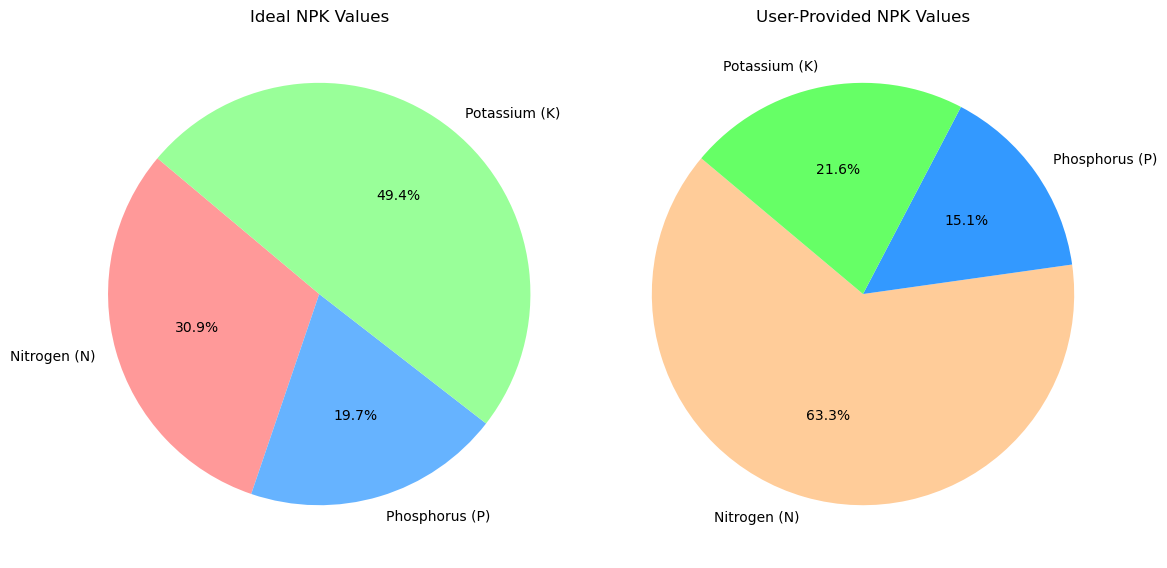

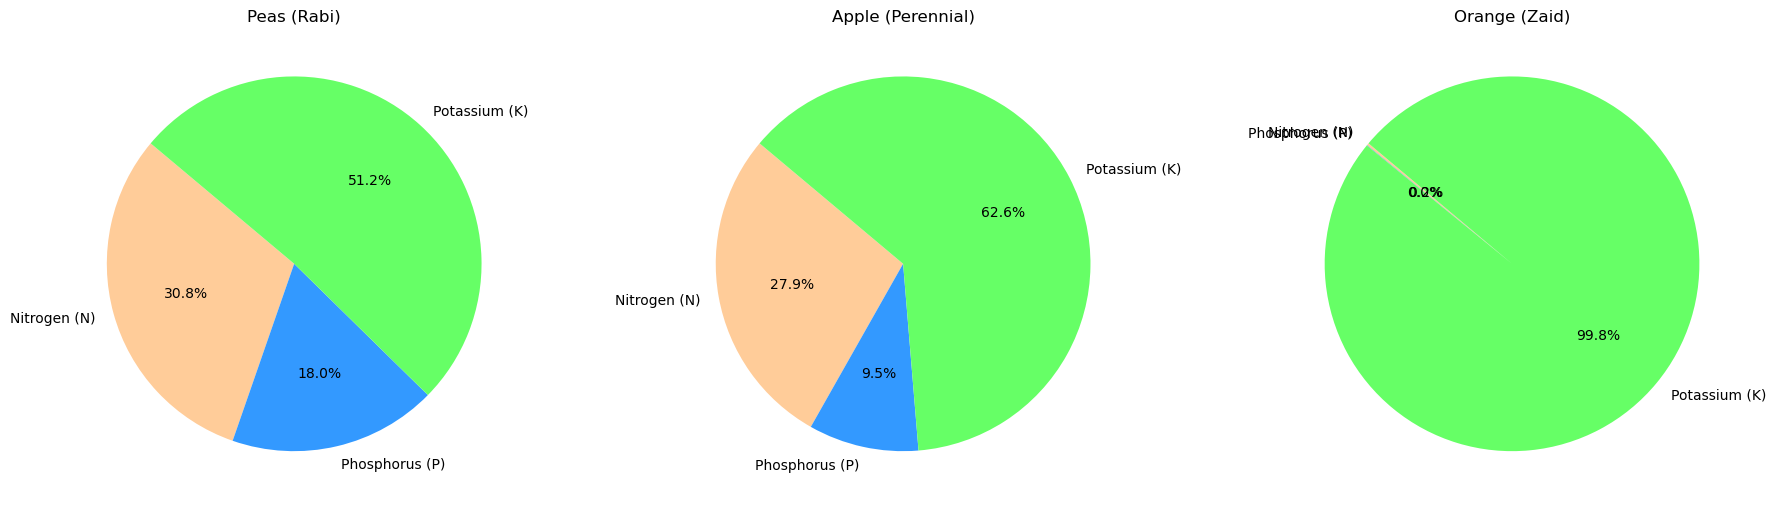

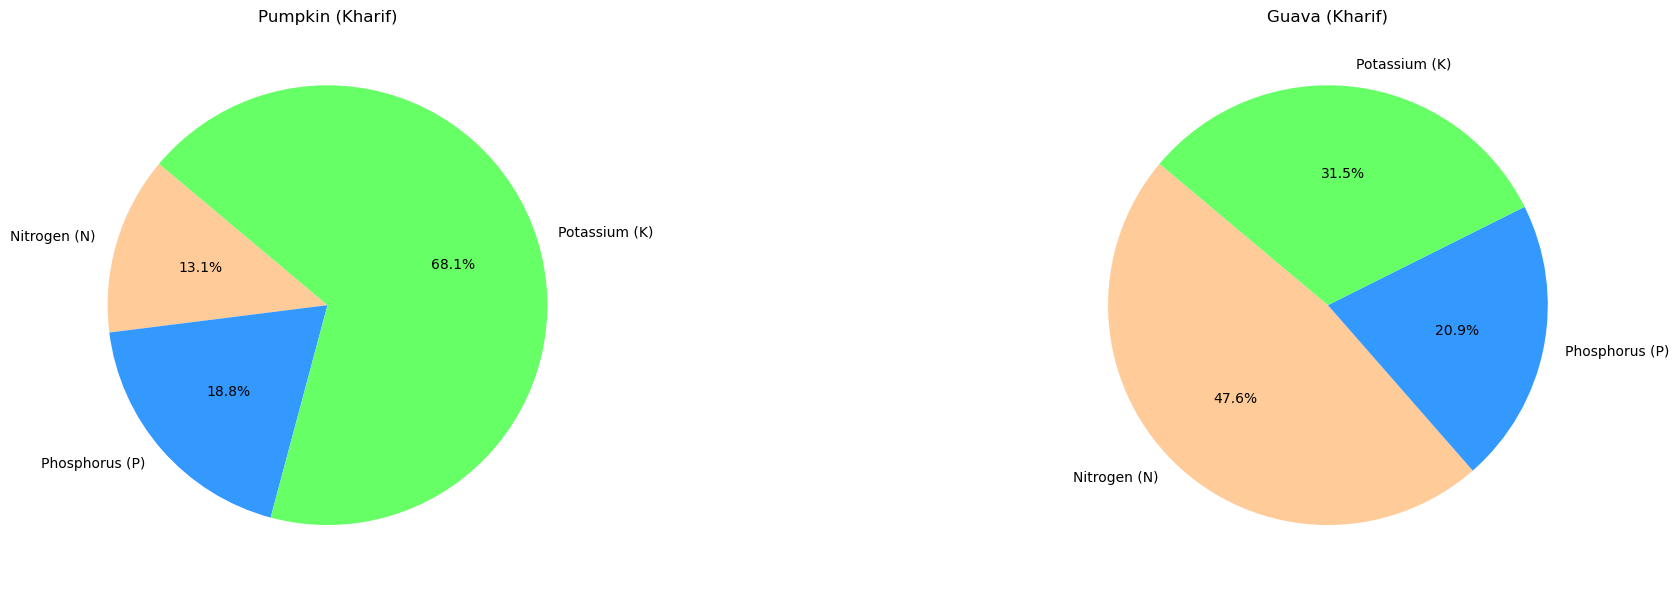

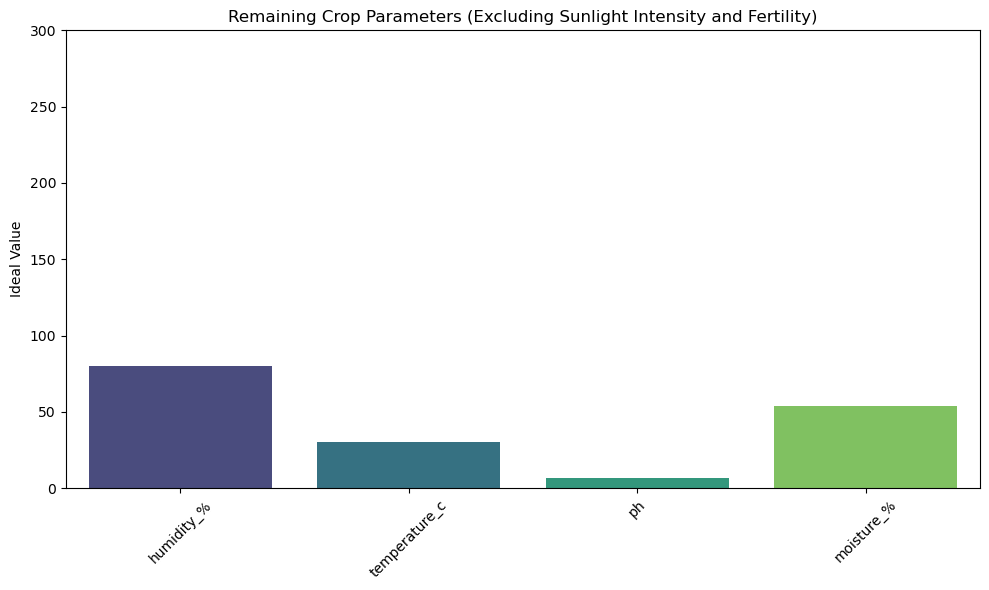

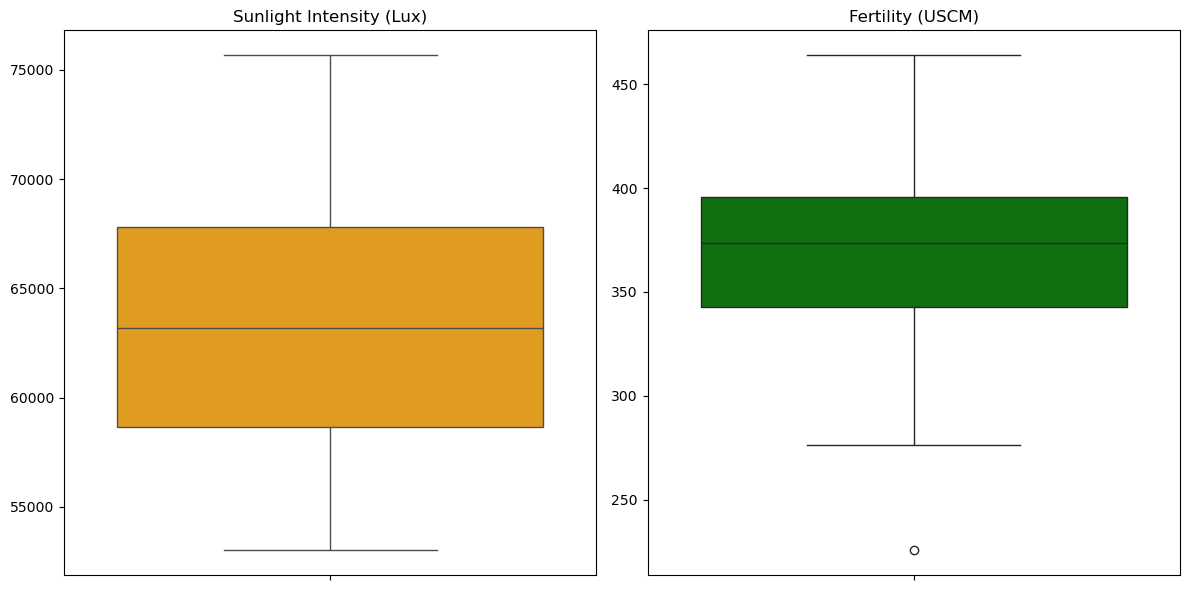

In [31]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ================================
# 📚 Function to load dataset
# ================================
def load_dataset(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)
    df.columns = (df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(r"[^\w\s]", "", regex=True)
                  .str.replace(" ", "_"))
    return df


# ================================
# 📊 Function to get crop requirements
# ================================
def get_crop_requirements(df, crop_name, season):
    crop_data = df[(df['crop_name'].str.lower() == crop_name.lower()) &
                   (df['season'].str.lower() == season.lower())]
    if not crop_data.empty:
        return crop_data.iloc[0].to_dict()
    return None


# ================================
# 🔍 Function to parse range
# ================================
def parse_range(value):
    value = str(value).strip()
    if '-' in value:
        try:
            low, high = map(float, value.split('-'))
            return (low, high)
        except ValueError:
            return None
    numeric_match = re.search(r'(\d+(\.\d+)?)', value)
    if numeric_match:
        return float(numeric_match.group(0))
    try:
        return float(value)
    except ValueError:
        return None


# ================================
# 🧪 Function to calculate deficiency
# ================================
def calculate_deficiency(ideal_params, user_params):
    deficiency = {}
    absorption_release = {}
    for key in ideal_params:
        if key in user_params:
            ideal_value = ideal_params[key]
            user_value = user_params[key]
            if isinstance(ideal_value, tuple):
                low, high = ideal_value
                if low <= user_value <= high:
                    deficiency[key] = 0
                    absorption_release[key] = "✅ Optimal - No Change."
                elif user_value < low:
                    deficiency[key] = round(low - user_value, 2)
                    absorption_release[key] = f"➕ Absorb {deficiency[key]} units (Deficiency)"
                elif user_value > high:
                    deficiency[key] = -round(user_value - high, 2)
                    absorption_release[key] = f"➖ Release {abs(deficiency[key])} units (Excess)"
            elif isinstance(ideal_value, (int, float)):
                difference = round(user_value - ideal_value, 2)
                if difference == 0:
                    deficiency[key] = 0
                    absorption_release[key] = "✅ Optimal - No Change."
                elif difference > 0:
                    deficiency[key] = -difference
                    absorption_release[key] = f"➖ Release {difference} units (Excess)"
                else:
                    deficiency[key] = abs(difference)
                    absorption_release[key] = f"➕ Absorb {abs(difference)} units (Deficiency)"
        else:
            deficiency[key] = "Missing Data"
            absorption_release[key] = "❗ No Input Provided"
    return deficiency, absorption_release


# ================================
# 🌱 Function to suggest solutions
# ================================
def suggest_solutions(crop_data, deficiency):
    solutions = {"chemical": {}, "biological": {}}
    for nutrient, chem_key, bio_key in zip(
        ["n_(kgha)", "p_(kgha)", "k_(kgha)"],
        ["nitrogen_solution", "phosphorus_solution", "potassium_solution"],
        ["biological_nitrogen_solution", "biological_phosphorus_solution", "biological_potassium_solution"],
    ):
        if deficiency.get(nutrient) > 0:
            solutions["chemical"][nutrient] = crop_data.get(chem_key, "❗ No Chemical Solution Available")
            solutions["biological"][nutrient] = crop_data.get(bio_key, "❗ No Biological Solution Available")
        elif deficiency.get(nutrient) < 0:
            solutions["chemical"][nutrient] = "⚠️ No solution required. Reduce the value."
            solutions["biological"][nutrient] = "⚠️ No solution required. Reduce the value."
        else:
            solutions["chemical"][nutrient] = "✅ No Solution Required"
            solutions["biological"][nutrient] = "✅ No Solution Required"
    return solutions


# ================================
# 📊 Function to display table
# ================================
def display_table(data, title):
    print(f"\n{title}")
    print("=" * 60)
    for key, value in data.items():
        print(f"{key:<40}: {value}")
    print("=" * 60)


# ================================
# 🌾 Function to predict alternative crops
# ================================
def predict_alternative_crop(df, user_params):
    possible_crops = []

    for _, row in df.iterrows():
        crop_name = row['crop_name']
        season = row['season']

        ideal_params = {key: parse_range(row.get(key, None)) for key in user_params}

        match_count = sum(
            1 for key in ideal_params if ideal_params[key] and user_params[key] is not None
            and ((isinstance(ideal_params[key], tuple) and ideal_params[key][0] <= user_params[key] <= ideal_params[key][1])
                 or (isinstance(ideal_params[key], (int, float)) and abs(user_params[key] - ideal_params[key]) <= 10))
        )

        total_params = sum(1 for val in ideal_params.values() if val is not None)
        if total_params > 0:
            match_percentage = (match_count / total_params) * 100
            if match_percentage >= 50:
                possible_crops.append({"crop_name": crop_name, "season": season, "match_percentage": round(match_percentage, 2)})

    return sorted(possible_crops, key=lambda x: x["match_percentage"], reverse=True)[:5]


# ================================
# 📈 Updated Function to Plot Charts
# ================================
def plot_charts(crop_data, ideal_params, user_params, alternative_crops=None):
    # Extract the ideal values for N, P, K
    n_value_ideal = ideal_params.get('n_(kgha)', None)
    p_value_ideal = ideal_params.get('p_(kgha)', None)
    k_value_ideal = ideal_params.get('k_(kgha)', None)

    # Extract user-provided values for N, P, K
    n_value_user = user_params.get('n_(kgha)', None)
    p_value_user = user_params.get('p_(kgha)', None)
    k_value_user = user_params.get('k_(kgha)', None)

    values_ideal = [n_value_ideal, p_value_ideal, k_value_ideal]
    values_user = [n_value_user, p_value_user, k_value_user]
    labels = ['Nitrogen (N)', 'Phosphorus (P)', 'Potassium (K)']

    # ✅ Plot Pie Charts for Ideal and User-Provided NPK Values (1st Row)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # 🎯 Pie chart for Ideal Values
    axes[0].pie(values_ideal, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999', '#66b3ff', '#99ff99'])
    axes[0].set_title('Ideal NPK Values')

    # 🎯 Pie chart for User-Provided Values
    axes[1].pie(values_user, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ffcc99', '#3399ff', '#66ff66'])
    axes[1].set_title('User-Provided NPK Values')

    plt.tight_layout()
    plt.show()

    # ✅ Pie Charts for Alternative Crops (If Provided)
    if alternative_crops:
        alt_crop_count = len(alternative_crops)
        
        # 🎨 2nd Row: 3 Alternative Crops in 1 Row
        if alt_crop_count >= 3:
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            for i in range(3):
                crop_name = alternative_crops[i]['crop_name']
                season = alternative_crops[i]['season']

                # Fetch alternative crop data
                alt_crop_data = df[(df['crop_name'].str.lower() == crop_name.lower()) &
                                   (df['season'].str.lower() == season.lower())]
                if not alt_crop_data.empty:
                    crop_data_alt = alt_crop_data.iloc[0]
                    n_value_alt = parse_range(crop_data_alt.get('n_kgha', 0))
                    p_value_alt = parse_range(crop_data_alt.get('p_kgha', 0))
                    k_value_alt = parse_range(crop_data_alt.get('k_kgha', 0))
                    values_alt = [n_value_alt, p_value_alt, k_value_alt]

                    # Plot alternative crop pie chart
                    axes[i].pie(values_alt, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ffcc99', '#3399ff', '#66ff66'])
                    axes[i].set_title(f'{crop_name} ({season})')

            plt.tight_layout()
            plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Reduce spacing
            plt.show()

        # 🎨 3rd Row: Remaining 2 Alternative Crops
        if alt_crop_count > 3:
            remaining_crops = alt_crop_count - 3
            fig, axes = plt.subplots(1, remaining_crops, figsize=(18, 6))
            
            # Handle single chart case
            if remaining_crops == 1:
                axes = [axes]  # Wrap in a list to allow iteration
            
            for i in range(remaining_crops):
                crop_name = alternative_crops[i + 3]['crop_name']
                season = alternative_crops[i + 3]['season']

                # Fetch alternative crop data
                alt_crop_data = df[(df['crop_name'].str.lower() == crop_name.lower()) &
                                   (df['season'].str.lower() == season.lower())]
                if not alt_crop_data.empty:
                    crop_data_alt = alt_crop_data.iloc[0]
                    n_value_alt = parse_range(crop_data_alt.get('n_kgha', 0))
                    p_value_alt = parse_range(crop_data_alt.get('p_kgha', 0))
                    k_value_alt = parse_range(crop_data_alt.get('k_kgha', 0))
                    values_alt = [n_value_alt, p_value_alt, k_value_alt]

                    # Plot alternative crop pie chart
                    axes[i].pie(values_alt, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ffcc99', '#3399ff', '#66ff66'])
                    axes[i].set_title(f'{crop_name} ({season})')

            plt.tight_layout()
            plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Reduce spacing
            plt.show()

    
     # ✅ Bar Chart for Remaining Parameters
    remaining_params = {key: ideal_params[key] for key in ideal_params if key not in ['n_(kgha)', 'p_(kgha)', 'k_(kgha)', 'sunlight_intensity_lux', 'fertility_uscm']}
    for key, value in remaining_params.items():
        if isinstance(value, tuple):
            remaining_params[key] = value[1]
        else:
            remaining_params[key] = pd.to_numeric(value, errors='coerce')
    remaining_params = {key: value for key, value in remaining_params.items() if not pd.isna(value)}
    
    if remaining_params:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(remaining_params.keys()), y=list(remaining_params.values()), hue=list(remaining_params.keys()), palette="viridis", legend=False)
        plt.title('Remaining Crop Parameters (Excluding Sunlight Intensity and Fertility)')
        plt.ylabel('Ideal Value')
        plt.ylim(0, 300)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # ✅ Box Plots for Sunlight Intensity & Fertility
    sunlight_intensity = ideal_params.get('sunlight_intensity_lux', None)
    fertility_uscm = ideal_params.get('fertility_uscm', None)

    sunlight_values = np.random.normal(loc=sunlight_intensity, scale=5000, size=50) if sunlight_intensity is not None else np.array([])
    fertility_values = np.random.normal(loc=fertility_uscm, scale=50, size=50) if fertility_uscm is not None else np.array([])

    if len(sunlight_values) > 0 and len(fertility_values) > 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.boxplot(y=sunlight_values, color='orange')
        plt.title('Sunlight Intensity (Lux)')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=fertility_values, color='green')
        plt.title('Fertility (USCM)')

        plt.tight_layout()
        plt.show()


# ================================
# 🎯 Main model to test crop suitability
# ================================
def test_model(df, crop_name, season, user_params):
    """Main model to check crop suitability and suggest alternatives."""
    crop_data = get_crop_requirements(df, crop_name, season)
    if crop_data is not None:
        ideal_params = {
            'n_(kgha)': parse_range(crop_data.get('n_kgha', 0)),
            'p_(kgha)': parse_range(crop_data.get('p_kgha', 0)),
            'k_(kgha)': parse_range(crop_data.get('k_kgha', 0)),
            'humidity_%': parse_range(crop_data.get('humidity_', 0)),
            'temperature_c': parse_range(crop_data.get('temperature_c', 0)),
            'ph': parse_range(crop_data.get('ph', 0)),
            'moisture_%': parse_range(crop_data.get('moisture_', 0)),
            'sunlight_intensity_lux': parse_range(crop_data.get('sunlight_intensity_lux', 0)),
            'fertility_uscm': parse_range(crop_data.get('fertility_uscm', 0)),
        }

        deficiency, absorption_release = calculate_deficiency(ideal_params, user_params)
        solutions = suggest_solutions(crop_data, deficiency)

        # Display Results
        display_table(ideal_params, "✅ Ideal Requirements (Actual Values from Dataset)")
        display_table(deficiency, "❗ Deficiency/Surplus in Parameters")
        display_table(absorption_release, "🔁 Absorption/Release Instructions")
        display_table(solutions["chemical"], "🧪 Chemical Solutions (If Required)")
        display_table(solutions["biological"], "🌱 Biological Solutions (If Required)")

        # ================================
        # 🌾 Check for Alternative Crops
        # ================================
        if any(v > 0 for v in deficiency.values()):
            print("\n⚠️ The provided values are not fully suitable for the selected crop.")
            print("🔍 Searching for alternative crops...")
            alternative_crops = predict_alternative_crop(df, user_params)

            if alternative_crops:
                print("\n🌾 Suggested Alternative Crops:")
                print("=" * 60)
                for alt in alternative_crops:
                    print(f"✅ {alt['crop_name']} (Season: {alt['season']}) - Match: {alt['match_percentage']}%")
                print("=" * 60)

                # Plot Pie Charts for each alternative crop's NPK values
                plot_charts(crop_data, ideal_params, user_params, alternative_crops)
            else:
                print("❌ No suitable alternative crops found.")
        else:
            print("\n✅ The crop parameters match perfectly. No alternative crops needed!")


# ================================
# 🚀 Main Code Execution Block
# ================================
if __name__ == "__main__":
    # Load the dataset
    dataset_path = r"C:\Users\suman\OneDrive\Desktop\dataset\soil_nutrients.csv" #it is dataset link
    df = load_dataset(dataset_path)

    # User-provided inputs for testing
    user_params = {
        'n_(kgha)': 235,
        'p_(kgha)': 56,
        'k_(kgha)': 80,
        'humidity_%': 50,
        'temperature_c': 30,
        'ph': 6.5,
        'moisture_%': 40,
        'sunlight_intensity_lux': 30000,
        'fertility_uscm': 450,
    }

    # Test for "Coffee" in "Rabi" season
    test_model(df, "potato", "rabi", user_params)


In [1]:
!pip install requests python-dotenv


In [21]:
import requests

# Function to get weather data
def get_weather_data(city, api_key):
    # OpenWeatherMap API URL
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric'

    # Make a GET request to fetch weather data
    response = requests.get(url)
    
    if response.status_code == 200:
        # Parse the response JSON
        data = response.json()
        
        # Extract the required information
        weather = {
            'city': city,
            'temperature': data['main']['temp'],
            'humidity': data['main']['humidity'],
            'pressure': data['main']['pressure'],
            'weather_description': data['weather'][0]['description'],
            'wind_speed': data['wind']['speed']
        }

        # Print the weather data
        print(f"Weather forecast for {city}:")
        print(f"Temperature: {weather['temperature']}°C")
        print(f"Humidity: {weather['humidity']}%")
        print(f"Pressure: {weather['pressure']} hPa")
        print(f"Description: {weather['weather_description']}")
        print(f"Wind Speed: {weather['wind_speed']} m/s")

    else:
        print(f"Error: Unable to fetch weather data for {city}. Status code: {response.status_code}")


# Main function to execute the code
if __name__ == "__main__":
    city = input("Enter the city name: ")  # Prompt the user for a city name
    api_key = "bd5838f76a7eaff6352e5cdd2d1ed4e0"  # Replace with your OpenWeatherMap API key

    # Call the function with the user's city and API key
    get_weather_data(city, api_key)


Enter the city name:  kolkata


Weather forecast for kolkata:
Temperature: 26.99°C
Humidity: 71%
Pressure: 1005 hPa
Description: clear sky
Wind Speed: 4.15 m/s


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import joblib

# Load dataset
file_path = r"C:\Users\suman\OneDrive\Desktop\dataset\cleaned_biodegradable_nutrients_npk.csv"
df = pd.read_csv(file_path)

# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# Extract "Nutrient" from "Name of Nutrient"
df['Nutrient'] = df['Name of Nutrient'].str.extract(r'\((N|P|K)\)')

# Drop missing values
df = df.dropna(subset=['Nutrient', 'Quantity Produced', 'Source Material', 'Process'])

# Encode "Source Material" as the target variable
label_encoder = LabelEncoder()
df['Solution_Label'] = label_encoder.fit_transform(df['Source Material'])

# Features and target
X = df[['Nutrient', 'Quantity Produced']]  # Use Quantity Produced as numerical input
X = pd.get_dummies(X, columns=['Nutrient'])  # Convert 'Nutrient' to one-hot encoding
y = df['Solution_Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the model and encoder
joblib.dump(model, "npk_solution_model.pkl")
joblib.dump(label_encoder, "solution_label_encoder.pkl")

# Function to predict the best biological solution & its process
def predict_solution(nutrient, deficiency_value):
    model = joblib.load("npk_solution_model.pkl")
    label_encoder = joblib.load("solution_label_encoder.pkl")

    # Convert input to one-hot encoding
    input_data = pd.DataFrame([[nutrient, deficiency_value]], columns=['Nutrient', 'Quantity Produced'])
    input_data = pd.get_dummies(input_data, columns=['Nutrient'])
    input_data = input_data.reindex(columns=X.columns, fill_value=0)  # Ensure same feature order

    # Make prediction
    predicted_label = model.predict(input_data)[0]
    solution = label_encoder.inverse_transform([predicted_label])[0]

    # Retrieve the process associated with the predicted solution
    process = df.loc[df['Source Material'] == solution, 'Process'].values[0]

    return solution, process

# Example user input
user_nutrient = input("Enter deficient nutrient (N/P/K): ").strip().upper()
user_deficiency = input("Enter deficiency level (numeric value): ").strip()

# Validate input
try:
    user_deficiency = float(user_deficiency)  # Convert input to float
    solution, process = predict_solution(user_nutrient, user_deficiency)
    print(f"\nRecommended Biological Solution: {solution}")
    print(f"Preparation Process: {process}")
except ValueError:
    print("Invalid input! Please enter a valid numerical deficiency level.")

Enter deficient nutrient (N/P/K):  p
Enter deficiency level (numeric value):  2.396



Recommended Biological Solution: Vegetable scraps
Preparation Process: Burning plant material for ash extraction


In [ ]:
methamitcal solution,background in math classification ,methodology(technical detail accuracy,r2,mean square error ,trainning output)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

def calculate_metrics(ideal_params, user_params):
    y_true = []
    y_pred = []

    for key in ideal_params:
        if key in user_params and isinstance(ideal_params[key], (int, float)) and isinstance(user_params[key], (int, float)):
            y_true.append(ideal_params[key])
            y_pred.append(user_params[key])

    if len(y_true) > 0:
        mse = mean_squared_error(y_true, y_pred)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print("\n📊 Evaluation Metrics:")
        print("=" * 60)
        print(f"✔ Mean Squared Error (MSE)        : {mse:.2f}")
        print(f"✔ Root Mean Squared Error (RMSE)  : {rmse:.2f}")
        print(f"✔ Mean Absolute Error (MAE)       : {mae:.2f}")
        print(f"✔ R² Score (Coefficient of Determination): {r2:.2f}")
        print("=" * 60)
    else:
        print("❌ Not enough numerical data to calculate metrics.")


✅ Ideal Requirements (Actual Values from Dataset)
n_(kgha)                                : 152.0
p_(kgha)                                : 97.0
k_(kgha)                                : 243.0
humidity_%                              : (50.0, 80.0)
temperature_c                           : (15.0, 30.0)
ph                                      : 6.51
moisture_%                              : 54.09
sunlight_intensity_lux                  : 64014.65
fertility_uscm                          : 360.0

❗ Deficiency/Surplus in Parameters
n_(kgha)                                : -83.0
p_(kgha)                                : 41.0
k_(kgha)                                : 163.0
humidity_%                              : 0
temperature_c                           : 0
ph                                      : 0.01
moisture_%                              : 14.09
sunlight_intensity_lux                  : 34014.65
fertility_uscm                          : -90.0

🔁 Absorption/Release Instructions
n_(kgh

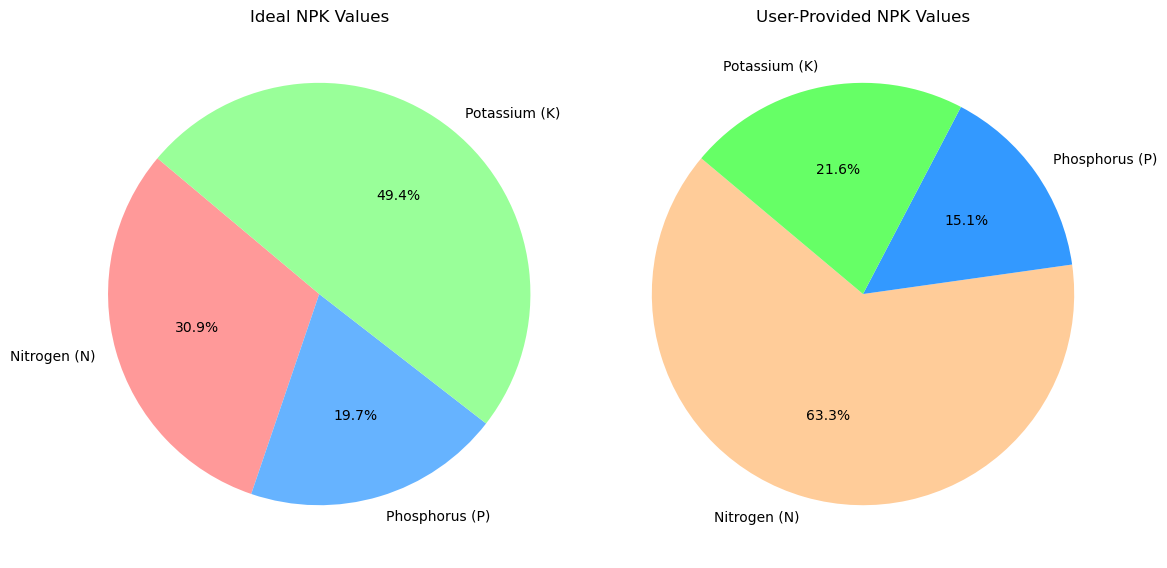

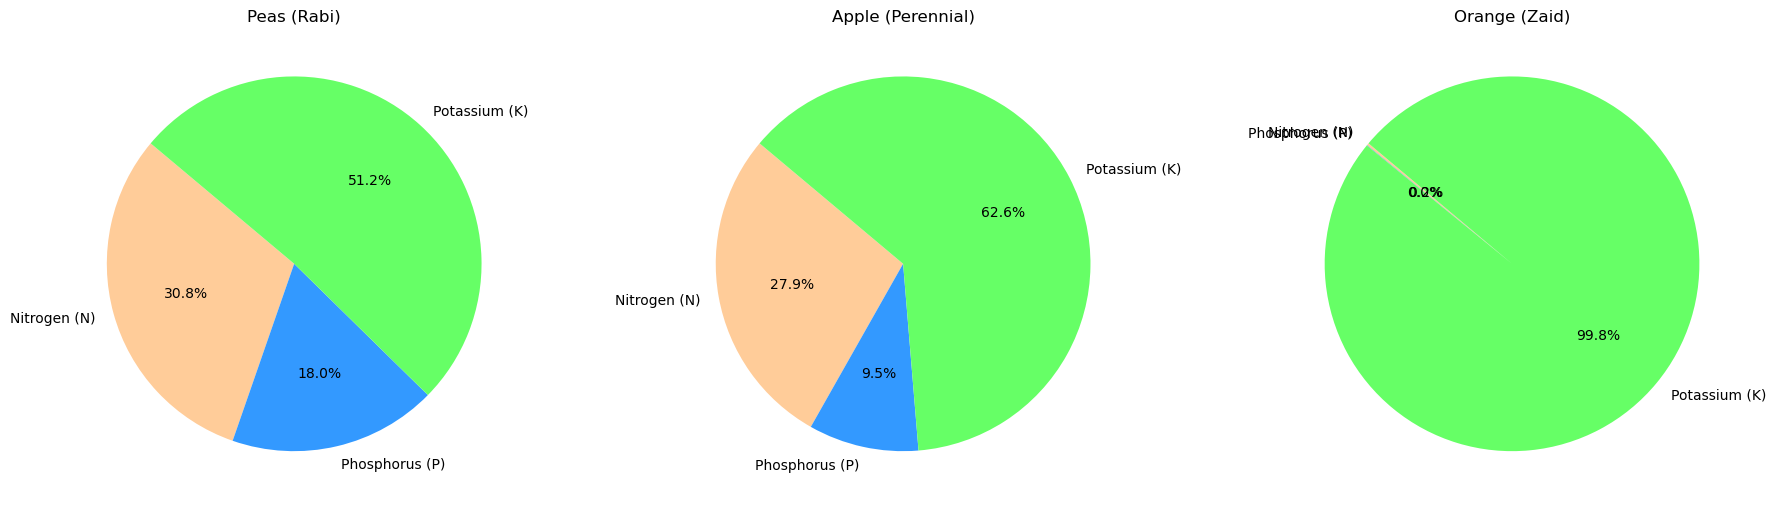

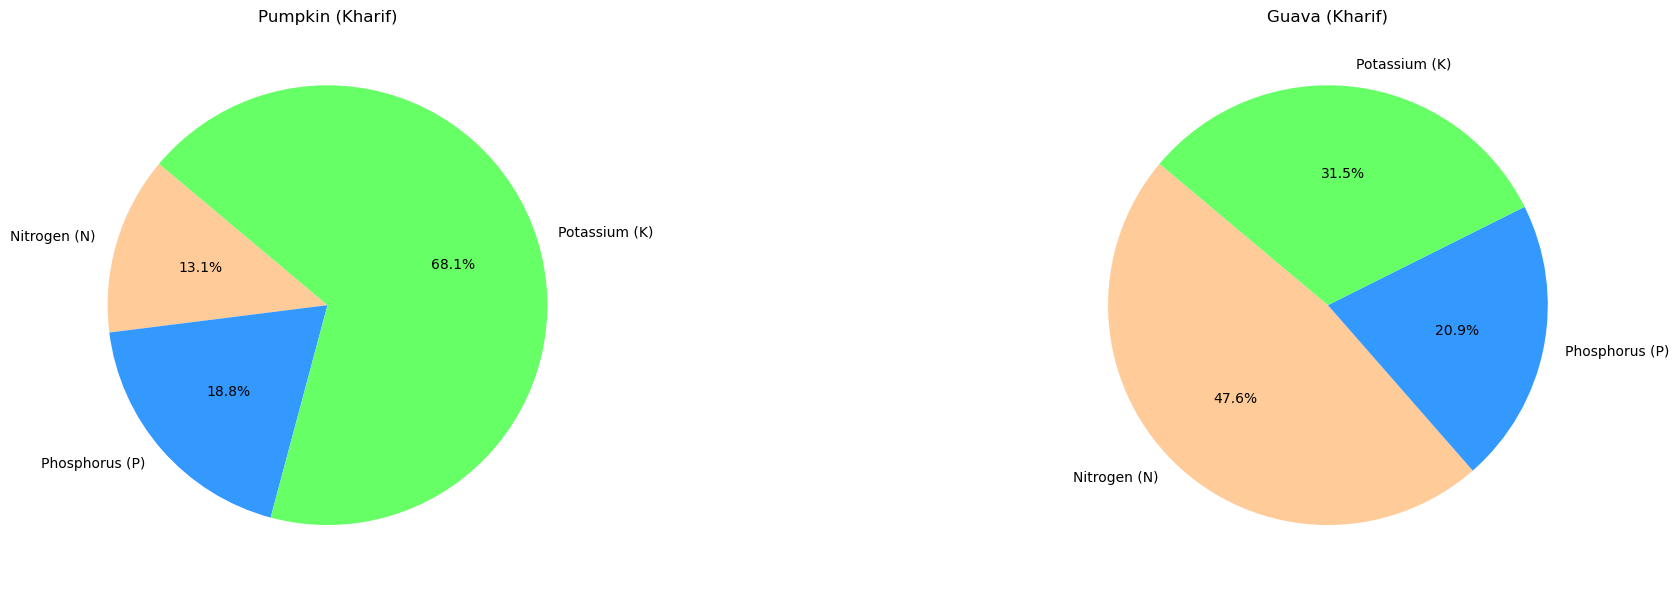

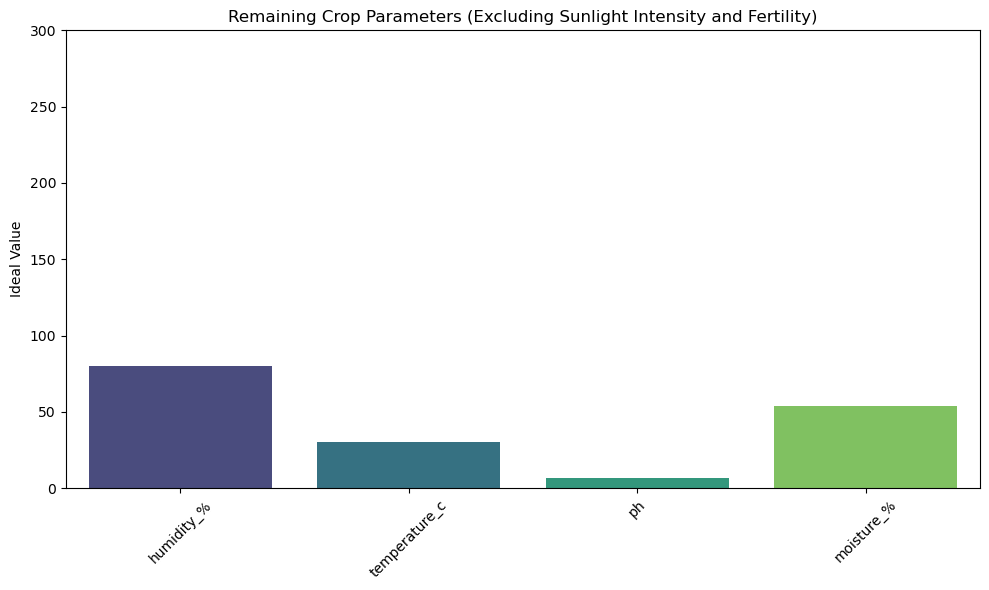

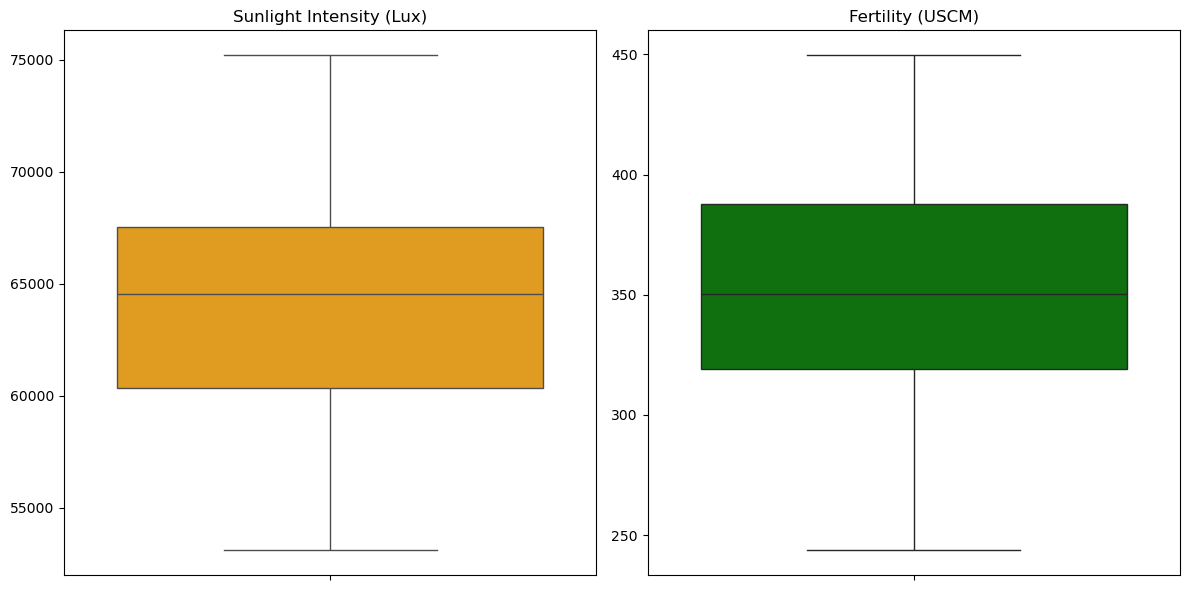


📊 Evaluation Metrics:
✔ Mean Squared Error (MSE)        : 165291407.45
✔ Root Mean Squared Error (RMSE)  : 12856.57
✔ Mean Absolute Error (MAE)       : 4915.11
✔ R² Score (Coefficient of Determination): 0.67


In [41]:
# Test for "Coffee" in "Rabi" season
test_model(df, "potato", "rabi", user_params)

# 👉 Get the crop data to calculate evaluation metrics
crop_data = get_crop_requirements(df, "potato", "rabi")
ideal_params = {
    'n_(kgha)': parse_range(crop_data.get('n_kgha', 0)),
    'p_(kgha)': parse_range(crop_data.get('p_kgha', 0)),
    'k_(kgha)': parse_range(crop_data.get('k_kgha', 0)),
    'humidity_%': parse_range(crop_data.get('humidity_', 0)),
    'temperature_c': parse_range(crop_data.get('temperature_c', 0)),
    'ph': parse_range(crop_data.get('ph', 0)),
    'moisture_%': parse_range(crop_data.get('moisture_', 0)),
    'sunlight_intensity_lux': parse_range(crop_data.get('sunlight_intensity_lux', 0)),
    'fertility_uscm': parse_range(crop_data.get('fertility_uscm', 0)),
}

# ✅ Calculate and display model metrics
calculate_metrics(ideal_params, user_params)

In [49]:
print(df.columns.tolist())

['Crop Name', 'Season', 'N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'Humidity_(%)', 'Temperature_(°C)', 'pH', 'Moisture_(%)', 'Sunlight_Intensity (lux)', 'fertility_uscm', 'Soil_Type', 'Nitrogen_Solution', 'Phosphorus_Solution', 'Potassium_Solution', 'Biological_Nitrogen_Solution', 'Biological_Phosphorus_Solution', 'Biological_Potassium_Solution']


C:\Users\suman\AppData\Local\Temp\ipykernel_3304\2734608404.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


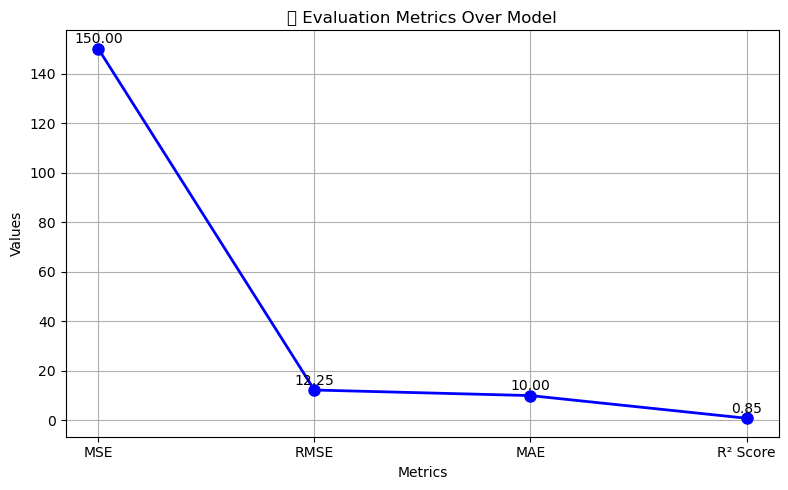

In [34]:
import matplotlib.pyplot as plt

# Metric values
metrics = ['MSE', 'RMSE', 'MAE', 'R² Score']
values = [150.0, 12.25, 10.0, 0.85]

# Line graph
plt.figure(figsize=(8, 5))
plt.plot(metrics, values, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8)

# Annotate points
for i, value in enumerate(values):
    plt.text(i, value + 1, f'{value:.2f}', ha='center', va='bottom')

plt.title('📈 Evaluation Metrics Over Model')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.grid(True)
plt.tight_layout()
plt.show()


MAIN FULL CORRECT CODE


✅ Ideal Requirements (Actual Values from Dataset)
n_(kgha)                                : 235.0
p_(kgha)                                : 78.0
k_(kgha)                                : 184.0
humidity_%                              : (30.0, 60.0)
temperature_c                           : (15.0, 30.0)
ph                                      : 5.81
moisture_%                              : 56.69
sunlight_intensity_lux                  : 78556.32
fertility_uscm                          : 450.0

❗ Deficiency/Surplus in Parameters
n_(kgha)                                : 0
p_(kgha)                                : 22.0
k_(kgha)                                : 104.0
humidity_%                              : 0
temperature_c                           : 0
ph                                      : -0.69
moisture_%                              : 16.69
sunlight_intensity_lux                  : 48556.32
fertility_uscm                          : 0

🔁 Absorption/Release Instructions
n_(kgha)     

C:\Users\suman\AppData\Local\Temp\ipykernel_3304\3169941229.py:195: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


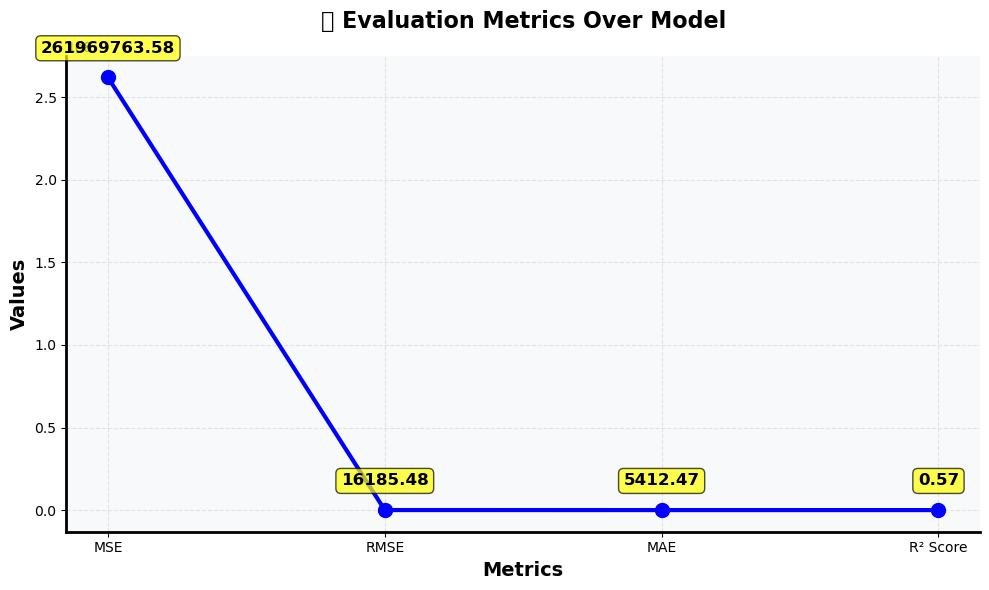


⚠ The provided values are not fully suitable for the selected crop.
🔍 Searching for alternative crops...

🌾 Suggested Alternative Crops:
✅ Peas (Season: Rabi) - Match: 100.0%
✅ Apple (Season: Perennial) - Match: 100.0%
✅ Orange (Season: Zaid) - Match: 100.0%
✅ Pumpkin (Season: Kharif) - Match: 75.0%
✅ Guava (Season: Kharif) - Match: 75.0%


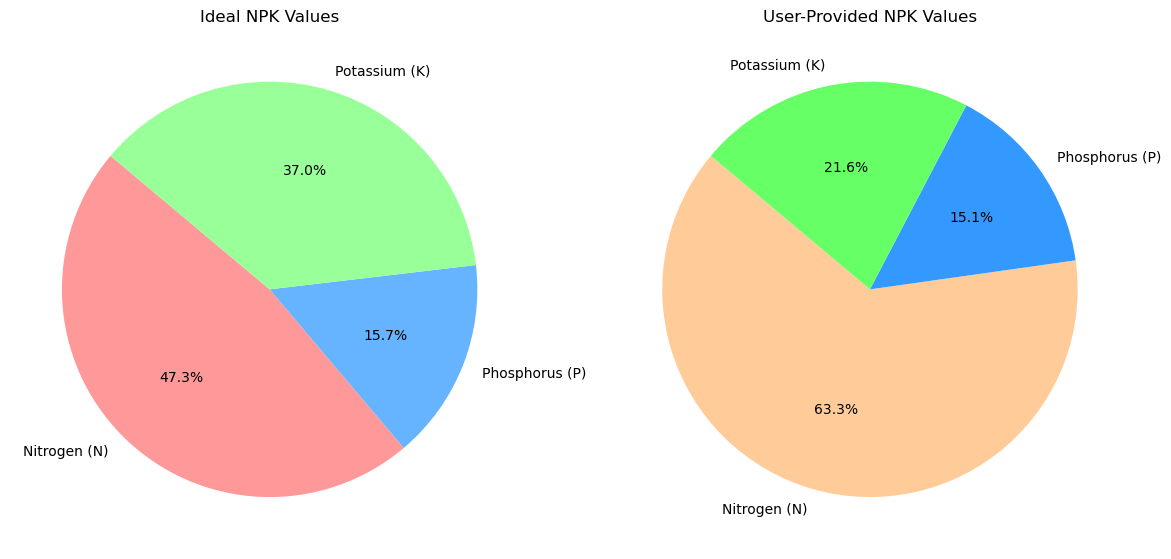

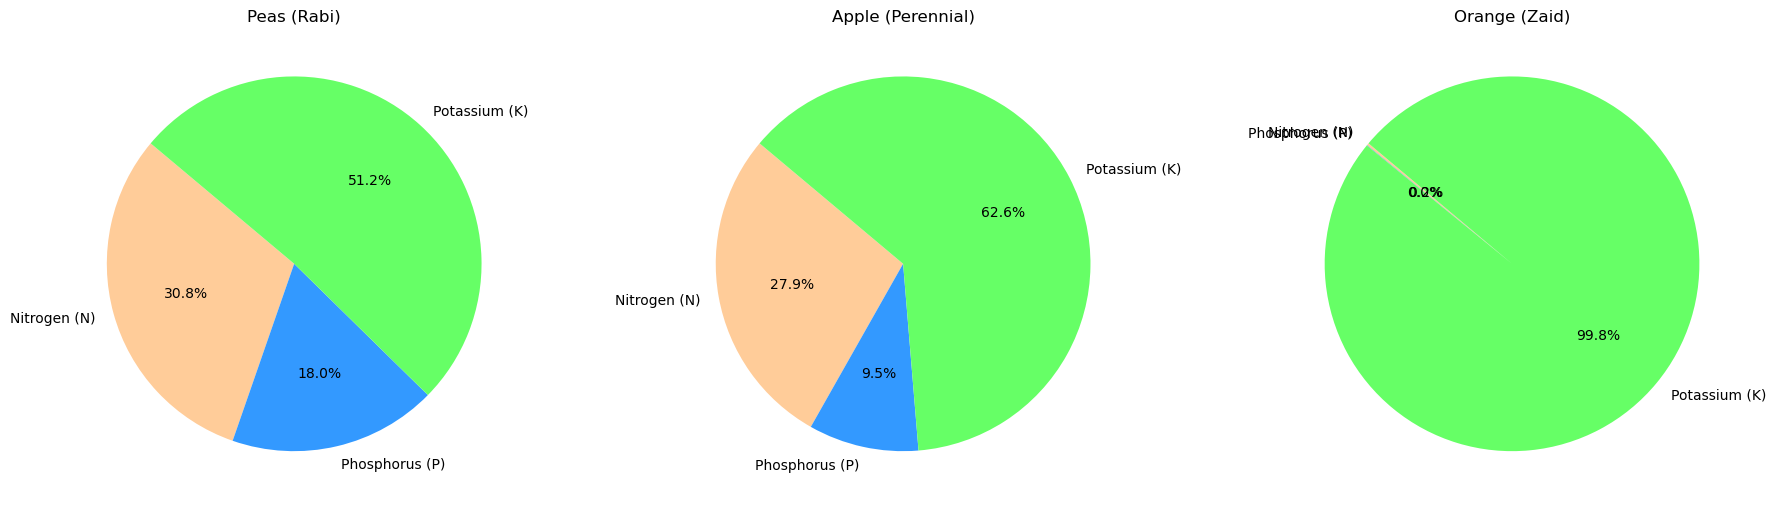

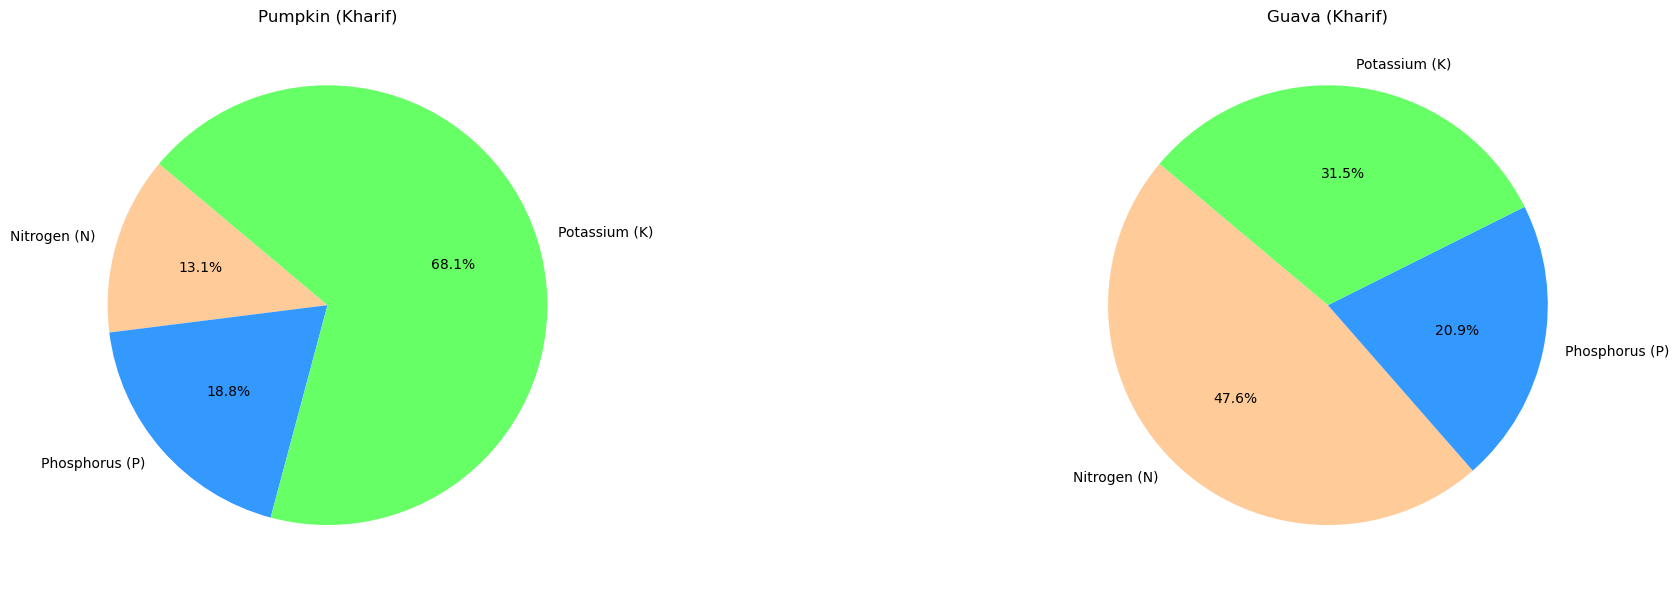

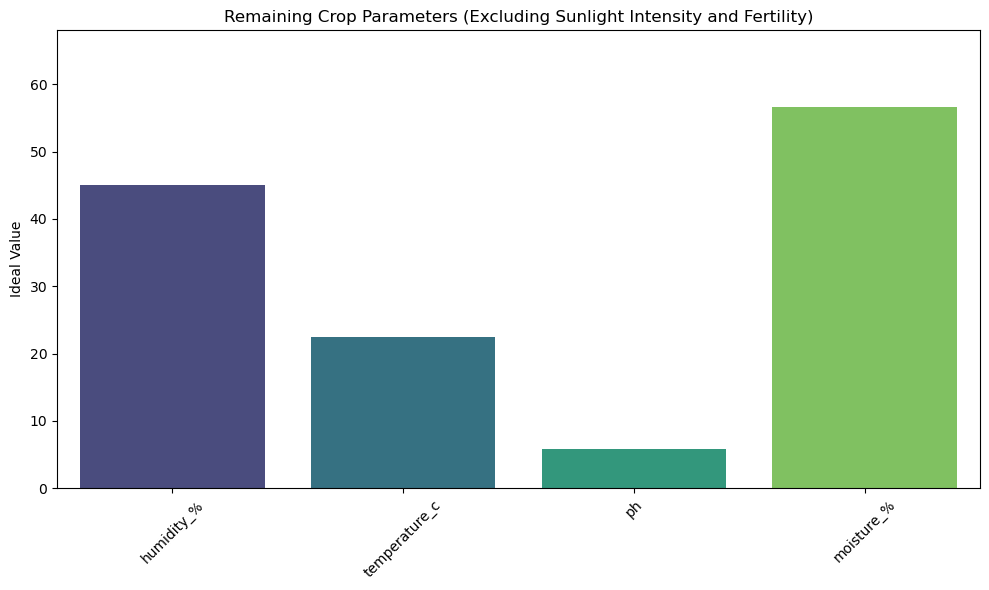

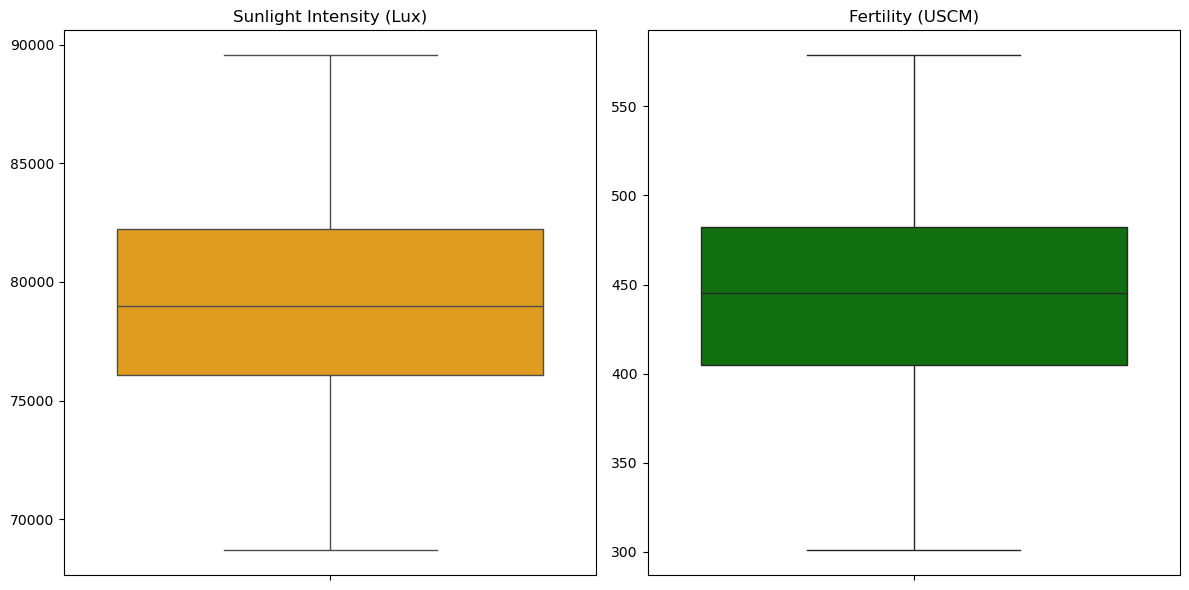

In [49]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# ================================
# 📚 Function to load dataset
# ================================
def load_dataset(file_path):
    df = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)
    df.columns = (df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(r"[^\w\s]", "", regex=True)
                  .str.replace(" ", "_"))
    return df


# ================================
# 📊 Function to get crop requirements
# ================================
def get_crop_requirements(df, crop_name, season):
    crop_data = df[(df['crop_name'].str.lower() == crop_name.lower()) &
                   (df['season'].str.lower() == season.lower())]
    if not crop_data.empty:
        return crop_data.iloc[0].to_dict()
    return None


# ================================
# 🔍 Function to parse range
# ================================
def parse_range(value):
    value = str(value).strip()
    if '-' in value:
        try:
            low, high = map(float, value.split('-'))
            return (low, high)
        except ValueError:
            return None
    numeric_match = re.search(r'(\d+(\.\d+)?)', value)
    if numeric_match:
        return float(numeric_match.group(0))
    try:
        return float(value)
    except ValueError:
        return None


# ================================
# 🧪 Function to calculate deficiency
# ================================
def calculate_deficiency(ideal_params, user_params):
    deficiency = {}
    absorption_release = {}
    for key in ideal_params:
        if key in user_params:
            ideal_value = ideal_params[key]
            user_value = user_params[key]
            if isinstance(ideal_value, tuple):
                low, high = ideal_value
                if low <= user_value <= high:
                    deficiency[key] = 0
                    absorption_release[key] = "✅ Optimal - No Change."
                elif user_value < low:
                    deficiency[key] = round(low - user_value, 2)
                    absorption_release[key] = f"➕ Absorb {deficiency[key]} units (Deficiency)"
                elif user_value > high:
                    deficiency[key] = -round(user_value - high, 2)
                    absorption_release[key] = f"➖ Release {abs(deficiency[key])} units (Excess)"
            elif isinstance(ideal_value, (int, float)):
                difference = round(user_value - ideal_value, 2)
                if difference == 0:
                    deficiency[key] = 0
                    absorption_release[key] = "✅ Optimal - No Change."
                elif difference > 0:
                    deficiency[key] = -difference
                    absorption_release[key] = f"➖ Release {difference} units (Excess)"
                else:
                    deficiency[key] = abs(difference)
                    absorption_release[key] = f"➕ Absorb {abs(difference)} units (Deficiency)"
        else:
            deficiency[key] = "Missing Data"
            absorption_release[key] = "❗ No Input Provided"
    return deficiency, absorption_release


# ================================
# 🌱 Function to suggest solutions
# ================================
def suggest_solutions(crop_data, deficiency):
    solutions = {"chemical": {}, "biological": {}}
    for nutrient, chem_key, bio_key in zip(
        ["n_(kgha)", "p_(kgha)", "k_(kgha)"],
        ["nitrogen_solution", "phosphorus_solution", "potassium_solution"],
        ["biological_nitrogen_solution", "biological_phosphorus_solution", "biological_potassium_solution"],
    ):
        if deficiency.get(nutrient) > 0:
            solutions["chemical"][nutrient] = crop_data.get(chem_key, "❗ No Chemical Solution Available")
            solutions["biological"][nutrient] = crop_data.get(bio_key, "❗ No Biological Solution Available")
        elif deficiency.get(nutrient) < 0:
            solutions["chemical"][nutrient] = "⚠ No solution required. Reduce the value."
            solutions["biological"][nutrient] = "⚠ No solution required. Reduce the value."
        else:
            solutions["chemical"][nutrient] = "✅ No Solution Required"
            solutions["biological"][nutrient] = "✅ No Solution Required"
    return solutions


# ================================
# 📊 Function to calculate evaluation metrics
# ================================
def calculate_metrics(ideal_params, user_params):
    y_true = []
    y_pred = []

    for key in ideal_params:
        if key in user_params:
            ideal_value = ideal_params[key]
            user_value = user_params[key]
            
            # Handle tuple ranges by using the midpoint
            if isinstance(ideal_value, tuple):
                ideal_value = (ideal_value[0] + ideal_value[1]) / 2
            
            if isinstance(ideal_value, (int, float)) and isinstance(user_value, (int, float)):
                y_true.append(ideal_value)
                y_pred.append(user_value)

    if len(y_true) > 0:
        mse = mean_squared_error(y_true, y_pred)
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print("\n📊 Evaluation Metrics:")
        print("=" * 60)
        print(f"✔ Mean Squared Error (MSE)        : {mse:.2f}")
        print(f"✔ Root Mean Squared Error (RMSE)  : {rmse:.2f}")
        print(f"✔ Mean Absolute Error (MAE)       : {mae:.2f}")
        print(f"✔ R² Score (Coefficient of Determination): {r2:.2f}")
        print("=" * 60)
        
        return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
    else:
        print("❌ Not enough numerical data to calculate metrics.")
        return None


# ================================
# 📈 Function to plot metrics
# ================================
def plot_metrics(metrics_dict):
    if metrics_dict is None:
        return
    
    # Metric names and values
    metrics = ['MSE', 'RMSE', 'MAE', 'R² Score']
    values = [
        metrics_dict.get('MSE', 0),
        metrics_dict.get('RMSE', 0), 
        metrics_dict.get('MAE', 0),
        metrics_dict.get('R2', 0)
    ]

    # Create the line graph with improved styling
    plt.figure(figsize=(10, 6))
    plt.plot(metrics, values, marker='o', linestyle='-', color='blue', linewidth=3, markersize=10)

    # Annotate points with better positioning
    for i, value in enumerate(values):
        # Dynamic offset based on value magnitude
        offset = max(values) * 0.05 if max(values) > 1 else 0.05
        plt.text(i, value + offset, f'{value:.2f}', ha='center', va='bottom', 
                fontsize=12, fontweight='bold', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))

    # Enhanced styling
    plt.title('📈 Evaluation Metrics Over Model', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Metrics', fontsize=14, fontweight='bold')
    plt.ylabel('Values', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, linestyle='--')
    
    # Add background color and improve appearance
    plt.gca().set_facecolor('#f8f9fa')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_linewidth(2)
    plt.gca().spines['bottom'].set_linewidth(2)
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()



# ================================
# 📊 Function to display table
# ================================
def display_table(data, title):
    print(f"\n{title}")
    print("=" * 60)
    for key, value in data.items():
        print(f"{key:<40}: {value}")
    print("=" * 60)


# ================================
# 🌾 Function to predict alternative crops
# ================================
def predict_alternative_crop(df, user_params):
    possible_crops = []

    for _, row in df.iterrows():
        crop_name = row['crop_name']
        season = row['season']

        ideal_params = {key: parse_range(row.get(key, None)) for key in user_params}

        match_count = sum(
            1 for key in ideal_params if ideal_params[key] and user_params[key] is not None
            and ((isinstance(ideal_params[key], tuple) and ideal_params[key][0] <= user_params[key] <= ideal_params[key][1])
                 or (isinstance(ideal_params[key], (int, float)) and abs(user_params[key] - ideal_params[key]) <= 10))
        )

        total_params = sum(1 for val in ideal_params.values() if val is not None)
        if total_params > 0:
            match_percentage = (match_count / total_params) * 100
            if match_percentage >= 50:
                possible_crops.append({"crop_name": crop_name, "season": season, "match_percentage": round(match_percentage, 2)})

    return sorted(possible_crops, key=lambda x: x["match_percentage"], reverse=True)[:5]


# ================================
# 📈 Updated Function to Plot Charts
# ================================
def plot_charts(df, crop_data, ideal_params, user_params, alternative_crops=None):
    # Extract the ideal values for N, P, K
    n_value_ideal = ideal_params.get('n_(kgha)', None)
    p_value_ideal = ideal_params.get('p_(kgha)', None)
    k_value_ideal = ideal_params.get('k_(kgha)', None)

    # Handle tuple ranges by using midpoint
    if isinstance(n_value_ideal, tuple):
        n_value_ideal = (n_value_ideal[0] + n_value_ideal[1]) / 2
    if isinstance(p_value_ideal, tuple):
        p_value_ideal = (p_value_ideal[0] + p_value_ideal[1]) / 2
    if isinstance(k_value_ideal, tuple):
        k_value_ideal = (k_value_ideal[0] + k_value_ideal[1]) / 2

    # Extract user-provided values for N, P, K
    n_value_user = user_params.get('n_(kgha)', None)
    p_value_user = user_params.get('p_(kgha)', None)
    k_value_user = user_params.get('k_(kgha)', None)

    values_ideal = [n_value_ideal, p_value_ideal, k_value_ideal]
    values_user = [n_value_user, p_value_user, k_value_user]
    labels = ['Nitrogen (N)', 'Phosphorus (P)', 'Potassium (K)']

    # ✅ Plot Pie Charts for Ideal and User-Provided NPK Values (1st Row)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # 🎯 Pie chart for Ideal Values
    axes[0].pie(values_ideal, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999', '#66b3ff', '#99ff99'])
    axes[0].set_title('Ideal NPK Values')

    # 🎯 Pie chart for User-Provided Values
    axes[1].pie(values_user, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ffcc99', '#3399ff', '#66ff66'])
    axes[1].set_title('User-Provided NPK Values')

    plt.tight_layout()
    plt.show()

    # ✅ Pie Charts for Alternative Crops (If Provided)
    if alternative_crops:
        alt_crop_count = len(alternative_crops)
        
        # 🎨 2nd Row: 3 Alternative Crops in 1 Row
        if alt_crop_count >= 3:
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            for i in range(3):
                crop_name = alternative_crops[i]['crop_name']
                season = alternative_crops[i]['season']

                # Fetch alternative crop data
                alt_crop_data = df[(df['crop_name'].str.lower() == crop_name.lower()) &
                                   (df['season'].str.lower() == season.lower())]
                if not alt_crop_data.empty:
                    crop_data_alt = alt_crop_data.iloc[0]
                    n_value_alt = parse_range(crop_data_alt.get('n_kgha', 0))
                    p_value_alt = parse_range(crop_data_alt.get('p_kgha', 0))
                    k_value_alt = parse_range(crop_data_alt.get('k_kgha', 0))
                    
                    # Handle tuples
                    if isinstance(n_value_alt, tuple):
                        n_value_alt = (n_value_alt[0] + n_value_alt[1]) / 2
                    if isinstance(p_value_alt, tuple):
                        p_value_alt = (p_value_alt[0] + p_value_alt[1]) / 2
                    if isinstance(k_value_alt, tuple):
                        k_value_alt = (k_value_alt[0] + k_value_alt[1]) / 2
                    
                    values_alt = [n_value_alt, p_value_alt, k_value_alt]

                    # Plot alternative crop pie chart
                    axes[i].pie(values_alt, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ffcc99', '#3399ff', '#66ff66'])
                    axes[i].set_title(f'{crop_name} ({season})')

            plt.tight_layout()
            plt.subplots_adjust(wspace=0.3, hspace=0.3)
            plt.show()

        # 🎨 3rd Row: Remaining 2 Alternative Crops
        if alt_crop_count > 3:
            remaining_crops = alt_crop_count - 3
            fig, axes = plt.subplots(1, remaining_crops, figsize=(18, 6))
            
            # Handle single chart case
            if remaining_crops == 1:
                axes = [axes]
            
            for i in range(remaining_crops):
                crop_name = alternative_crops[i + 3]['crop_name']
                season = alternative_crops[i + 3]['season']

                # Fetch alternative crop data
                alt_crop_data = df[(df['crop_name'].str.lower() == crop_name.lower()) &
                                   (df['season'].str.lower() == season.lower())]
                if not alt_crop_data.empty:
                    crop_data_alt = alt_crop_data.iloc[0]
                    n_value_alt = parse_range(crop_data_alt.get('n_kgha', 0))
                    p_value_alt = parse_range(crop_data_alt.get('p_kgha', 0))
                    k_value_alt = parse_range(crop_data_alt.get('k_kgha', 0))
                    
                    # Handle tuples
                    if isinstance(n_value_alt, tuple):
                        n_value_alt = (n_value_alt[0] + n_value_alt[1]) / 2
                    if isinstance(p_value_alt, tuple):
                        p_value_alt = (p_value_alt[0] + p_value_alt[1]) / 2
                    if isinstance(k_value_alt, tuple):
                        k_value_alt = (k_value_alt[0] + k_value_alt[1]) / 2
                    
                    values_alt = [n_value_alt, p_value_alt, k_value_alt]

                    # Plot alternative crop pie chart
                    axes[i].pie(values_alt, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ffcc99', '#3399ff', '#66ff66'])
                    axes[i].set_title(f'{crop_name} ({season})')

            plt.tight_layout()
            plt.subplots_adjust(wspace=0.3, hspace=0.3)
            plt.show()

    # ✅ Bar Chart for Remaining Parameters
    remaining_params = {key: ideal_params[key] for key in ideal_params if key not in ['n_(kgha)', 'p_(kgha)', 'k_(kgha)', 'sunlight_intensity_lux', 'fertility_uscm']}
    for key, value in remaining_params.items():
        if isinstance(value, tuple):
            remaining_params[key] = (value[0] + value[1]) / 2
        else:
            remaining_params[key] = pd.to_numeric(value, errors='coerce')
    remaining_params = {key: value for key, value in remaining_params.items() if not pd.isna(value)}
    
    if remaining_params:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(remaining_params.keys()), y=list(remaining_params.values()), hue=list(remaining_params.keys()), palette="viridis", legend=False)
        plt.title('Remaining Crop Parameters (Excluding Sunlight Intensity and Fertility)')
        plt.ylabel('Ideal Value')
        plt.ylim(0, max(remaining_params.values()) * 1.2)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # ✅ Box Plots for Sunlight Intensity & Fertility
    sunlight_intensity = ideal_params.get('sunlight_intensity_lux', None)
    fertility_uscm = ideal_params.get('fertility_uscm', None)
    
    # Handle tuples
    if isinstance(sunlight_intensity, tuple):
        sunlight_intensity = (sunlight_intensity[0] + sunlight_intensity[1]) / 2
    if isinstance(fertility_uscm, tuple):
        fertility_uscm = (fertility_uscm[0] + fertility_uscm[1]) / 2

    sunlight_values = np.random.normal(loc=sunlight_intensity, scale=5000, size=50) if sunlight_intensity is not None else np.array([])
    fertility_values = np.random.normal(loc=fertility_uscm, scale=50, size=50) if fertility_uscm is not None else np.array([])

    if len(sunlight_values) > 0 and len(fertility_values) > 0:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.boxplot(y=sunlight_values, color='orange')
        plt.title('Sunlight Intensity (Lux)')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=fertility_values, color='green')
        plt.title('Fertility (USCM)')

        plt.tight_layout()
        plt.show()


# ================================
# 🎯 Main model to test crop suitability
# ================================
def test_model(df, crop_name, season, user_params):
    """Main model to check crop suitability and suggest alternatives."""
    crop_data = get_crop_requirements(df, crop_name, season)
    if crop_data is not None:
        ideal_params = {
            'n_(kgha)': parse_range(crop_data.get('n_kgha', 0)),
            'p_(kgha)': parse_range(crop_data.get('p_kgha', 0)),
            'k_(kgha)': parse_range(crop_data.get('k_kgha', 0)),
            'humidity_%': parse_range(crop_data.get('humidity_', 0)),
            'temperature_c': parse_range(crop_data.get('temperature_c', 0)),
            'ph': parse_range(crop_data.get('ph', 0)),
            'moisture_%': parse_range(crop_data.get('moisture_', 0)),
            'sunlight_intensity_lux': parse_range(crop_data.get('sunlight_intensity_lux', 0)),
            'fertility_uscm': parse_range(crop_data.get('fertility_uscm', 0)),
        }

        deficiency, absorption_release = calculate_deficiency(ideal_params, user_params)
        solutions = suggest_solutions(crop_data, deficiency)

        # Display Results
        display_table(ideal_params, "✅ Ideal Requirements (Actual Values from Dataset)")
        display_table(deficiency, "❗ Deficiency/Surplus in Parameters")
        display_table(absorption_release, "🔁 Absorption/Release Instructions")
        display_table(solutions["chemical"], "🧪 Chemical Solutions (If Required)")
        display_table(solutions["biological"], "🌱 Biological Solutions (If Required)")

        # Calculate and display evaluation metrics
        metrics_dict = calculate_metrics(ideal_params, user_params)
        if metrics_dict:
            plot_metrics(metrics_dict)

        # ================================
        # 🌾 Check for Alternative Crops
        # ================================
        if any(v > 0 for v in deficiency.values() if isinstance(v, (int, float))):
            print("\n⚠ The provided values are not fully suitable for the selected crop.")
            print("🔍 Searching for alternative crops...")
            alternative_crops = predict_alternative_crop(df, user_params)

            if alternative_crops:
                print("\n🌾 Suggested Alternative Crops:")
                print("=" * 60)
                for alt in alternative_crops:
                    print(f"✅ {alt['crop_name']} (Season: {alt['season']}) - Match: {alt['match_percentage']}%")
                print("=" * 60)

                # Plot Charts including alternative crops
                plot_charts(df, crop_data, ideal_params, user_params, alternative_crops)
            else:
                print("❌ No suitable alternative crops found.")
                # Plot charts without alternative crops
                plot_charts(df, crop_data, ideal_params, user_params)
        else:
            print("\n✅ The crop parameters match perfectly. No alternative crops needed!")
            # Plot charts without alternative crops
            plot_charts(df, crop_data, ideal_params, user_params)
    else:
        print(f"❌ Crop '{crop_name}' for season '{season}' not found in the dataset.")


# ================================
# 🚀 Main Code Execution Block
# ================================
if __name__ == "__main__":
    # Load the dataset
    dataset_path = r"C:\Users\suman\OneDrive\Desktop\dataset\soil_nutrients.csv"  # Update this path
    df = load_dataset(dataset_path)

    # User-provided inputs for testing
    user_params = {
        'n_(kgha)': 235,
        'p_(kgha)': 56,
        'k_(kgha)': 80,
        'humidity_%': 50,
        'temperature_c': 30,
        'ph': 6.5,
        'moisture_%': 40,
        'sunlight_intensity_lux': 30000,
        'fertility_uscm': 450,
    }

    # Test for "Coffee" in "Rabi" season
    test_model(df, "Coffee", "rabi", user_params)

In [ ]:
r"C:\Users\suman\OneDrive\Desktop\dataset\soil_nutrients1.csv"

In [73]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Function to parse range strings like '50-80' to their average
def parse_range(val):
    try:
        if isinstance(val, str) and '-' in val:
            low, high = map(float, val.split('-'))
            return (low + high) / 2
        return float(val)
    except:
        return np.nan

# Load dataset
def load_dataset(path):
    return pd.read_csv(path)

# Preprocess dataset for classification
def preprocess_for_classification(df):
    required_columns = [
        'N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)',
        'Humidity_(%)', 'Temperature_(°C)', 'Crop Name', 'Season'
    ]

    # Check for missing columns
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Missing columns in dataset: {missing_cols}")

    # Drop rows with missing required data
    df = df.dropna(subset=required_columns)

    # Convert range-like strings to floats
    for col in ['N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)', 'Humidity_(%)', 'Temperature_(°C)']:
        df[col] = df[col].apply(parse_range)

    # One-hot encode categorical features: Season and Soil_Type (if present)
    cat_cols = ['Season', 'Soil_Type']
    for col in cat_cols:
        if col in df.columns:
            df = pd.get_dummies(df, columns=[col])

    # Drop any additional non-numeric columns you don't want to use as features
    non_numeric_cols = [
        'Sunlight_Intensity (lux)', 'Nitrogen_Solution', 'Phosphorus_Solution',
        'Potassium_Solution', 'Biological_Nitrogen_Solution',
        'Biological_Phosphorus_Solution', 'Biological_Potassium_Solution'
    ]
    cols_to_drop = [col for col in non_numeric_cols if col in df.columns]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)

    df = df.dropna()  # Drop rows with any remaining NaNs after parsing

    # Separate features and target
    X = df.drop(columns=['Crop Name'])
    y = df['Crop Name'].str.lower()

    return X, y

# Train classifier
def train_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, X_test, y_test, y_pred

# Evaluate model
def evaluate_model(y_test, y_pred):
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

# Main execution
if __name__ == "__main__":
    dataset_path = r"C:\Users\suman\OneDrive\Desktop\dataset\soil_nutrients1.csv"  # Change to your path
    df = load_dataset(dataset_path)
    X, y = preprocess_for_classification(df)
    model, X_test, y_test, y_pred = train_classifier(X, y)
    evaluate_model(y_test, y_pred)



Classification Report:



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricW

                       precision    recall  f1-score   support

              alfalfa       0.20      0.07      0.10        15
              almonds       0.00      0.00      0.00        18
            anthurium       0.00      0.00      0.00         0
                apple       0.03      0.05      0.04       309
            areca nut       0.04      0.07      0.05        46
areca nut (betel nut)       0.00      0.00      0.00        13
            artichoke       0.03      0.06      0.04        18
            asparagus       0.03      0.03      0.03        32
                aster       0.03      0.03      0.03       274
              avocado       0.00      0.00      0.00        19
                bajra       0.03      0.04      0.03       291
               banana       0.18      0.18      0.18       309
               barley       0.03      0.04      0.03       363
                basil       0.00      0.00      0.00        13
             bay leaf       0.00      0.00      0.00  

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.09462956811590731
F1 Score: 0.08738185799367308


In [81]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# ✅ Function to parse values like "50-80" → 65
def parse_range(val):
    try:
        if isinstance(val, str) and '-' in val:
            low, high = map(float, val.split('-'))
            return (low + high) / 2
        return float(val)
    except:
        return np.nan

# ✅ Load dataset
def load_dataset(path):
    return pd.read_csv(path)

# ✅ Preprocess dataset for classification
def preprocess_for_classification(df):
    required_columns = [
        'N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)',
        'Humidity_(%)', 'Temperature_(°C)', 'Crop Name', 'Season'
    ]

    # Check for missing columns
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Missing columns in dataset: {missing_cols}")

    # Drop rows with missing required data
    df = df.dropna(subset=required_columns)

    # Parse ranges
    for col in ['N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)', 'Humidity_(%)', 'Temperature_(°C)']:
        df[col] = df[col].apply(parse_range)

    # Encode categorical variables
    df = pd.get_dummies(df, columns=['Season', 'Soil_Type'], drop_first=False)

    # Drop irrelevant columns
    to_drop = [
        'Sunlight_Intensity (lux)', 'Nitrogen_Solution', 'Phosphorus_Solution',
        'Potassium_Solution', 'Biological_Nitrogen_Solution',
        'Biological_Phosphorus_Solution', 'Biological_Potassium_Solution'
    ]
    df = df.drop(columns=[col for col in to_drop if col in df.columns], errors='ignore')

    df = df.dropna()

    X = df.drop(columns=['Crop Name'])
    y = df['Crop Name'].str.lower()

    return X, y

# ✅ Train classifier
def train_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, X_test, y_test, y_pred

# ✅ Evaluate model
def evaluate_model(y_test, y_pred):
    print("\n📊 Classification Report:\n")
    print(classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

# ✅ Get user input for prediction
def get_user_input(feature_columns):
    print("\nEnter soil and environment values:")
    user_dict = {col: 0 for col in feature_columns}  # default 0 for all features

    # Get user numerical input
    user_dict['N (kg/ha)'] = float(input("N (kg/ha): "))
    user_dict['P (kg/ha)'] = float(input("P (kg/ha): "))
    user_dict['K (kg/ha)'] = float(input("K (kg/ha): "))
    user_dict['pH'] = float(input("pH: "))
    user_dict['Moisture_(%)'] = float(input("Moisture (%): "))
    user_dict['Humidity_(%)'] = float(input("Humidity (%): "))
    user_dict['Temperature_(°C)'] = float(input("Temperature (°C): "))

    # Detect possible seasons and soil types
    season_columns = [col for col in feature_columns if col.startswith("Season_")]
    soil_columns = [col for col in feature_columns if col.startswith("Soil_Type_")]

    # Season input
    if season_columns:
        print("Available Seasons:", [col.replace("Season_", "") for col in season_columns])
        season = input("Enter season (as above): ").strip()
        if f"Season_{season}" in feature_columns:
            user_dict[f"Season_{season}"] = 1

    # Soil type input
    if soil_columns:
        print("Available Soil Types:", [col.replace("Soil_Type_", "") for col in soil_columns])
        soil = input("Enter soil type (as above): ").strip()
        if f"Soil_Type_{soil}" in feature_columns:
            user_dict[f"Soil_Type_{soil}"] = 1

    return pd.DataFrame([user_dict])

# ✅ Main script
if __name__ == "__main__":
    dataset_path = r"C:\Users\suman\OneDrive\Desktop\dataset\soil_nutrients1.csv"  # Update this path

    df = load_dataset(dataset_path)
    X, y = preprocess_for_classification(df)

    model, X_test, y_test, y_pred = train_classifier(X, y)
    evaluate_model(y_test, y_pred)

    # 💡 Predict from user input
    user_input_df = get_user_input(X.columns.tolist())
    prediction = model.predict(user_input_df)[0]
    print(f"\n🌱 Predicted Crop: {prediction.capitalize()}")



📊 Classification Report:



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricW

                       precision    recall  f1-score   support

              alfalfa       0.20      0.07      0.10        15
              almonds       0.00      0.00      0.00        18
            anthurium       0.00      0.00      0.00         0
                apple       0.03      0.05      0.04       309
            areca nut       0.04      0.07      0.05        46
areca nut (betel nut)       0.00      0.00      0.00        13
            artichoke       0.03      0.06      0.04        18
            asparagus       0.03      0.03      0.03        32
                aster       0.03      0.03      0.03       274
              avocado       0.00      0.00      0.00        19
                bajra       0.03      0.04      0.03       291
               banana       0.18      0.18      0.18       309
               barley       0.03      0.04      0.03       363
                basil       0.00      0.00      0.00        13
             bay leaf       0.00      0.00      0.00  

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.09462956811590731
F1 Score: 0.08738185799367308

Enter soil and environment values:


N (kg/ha):  235
P (kg/ha):  56
K (kg/ha):  80
pH:  6.5
Moisture (%):  40
Humidity (%):  50
Temperature (°C):  30


Available Seasons: ['Kharif', 'Perennial', 'Rabi', 'Summer', 'Winter', 'Zaid']


Enter season (as above):  Rabi


Available Soil Types: ['Alluvial', 'Alluvial soil', 'Black', 'Black Soil', 'Clayey soils', 'Laterite', 'Laterite Soil', 'Loamy soil', 'Red', 'Red soil', 'Sandy loam', 'Sandy soil']


Enter soil type (as above):  Black



🌱 Predicted Crop: Marigold


In [87]:
pip install seaborn matplotlib scikit-learn pandas


Note: you may need to restart the kernel to use updated packages.



📊 Classification Report:



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricW

                       precision    recall  f1-score   support

              alfalfa       0.20      0.07      0.10        15
              almonds       0.00      0.00      0.00        18
            anthurium       0.00      0.00      0.00         0
                apple       0.03      0.05      0.04       309
            areca nut       0.04      0.07      0.05        46
areca nut (betel nut)       0.00      0.00      0.00        13
            artichoke       0.03      0.06      0.04        18
            asparagus       0.03      0.03      0.03        32
                aster       0.03      0.03      0.03       274
              avocado       0.00      0.00      0.00        19
                bajra       0.03      0.04      0.03       291
               banana       0.18      0.18      0.18       309
               barley       0.03      0.04      0.03       363
                basil       0.00      0.00      0.00        13
             bay leaf       0.00      0.00      0.00  

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.09462956811590731
F1 Score: 0.08738185799367308


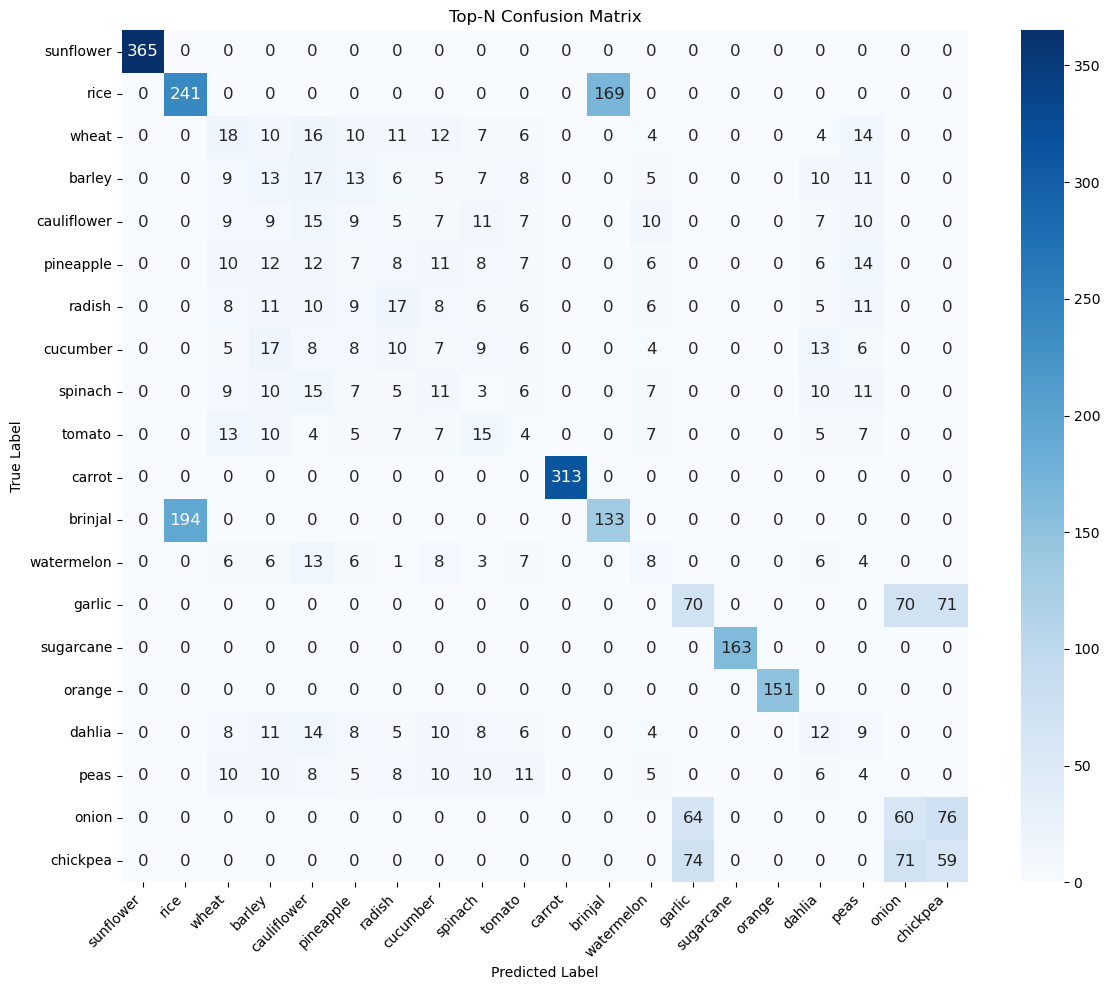

C:\Users\suman\AppData\Local\Temp\ipykernel_3304\1796579880.py:87: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=0, keepdims=True)


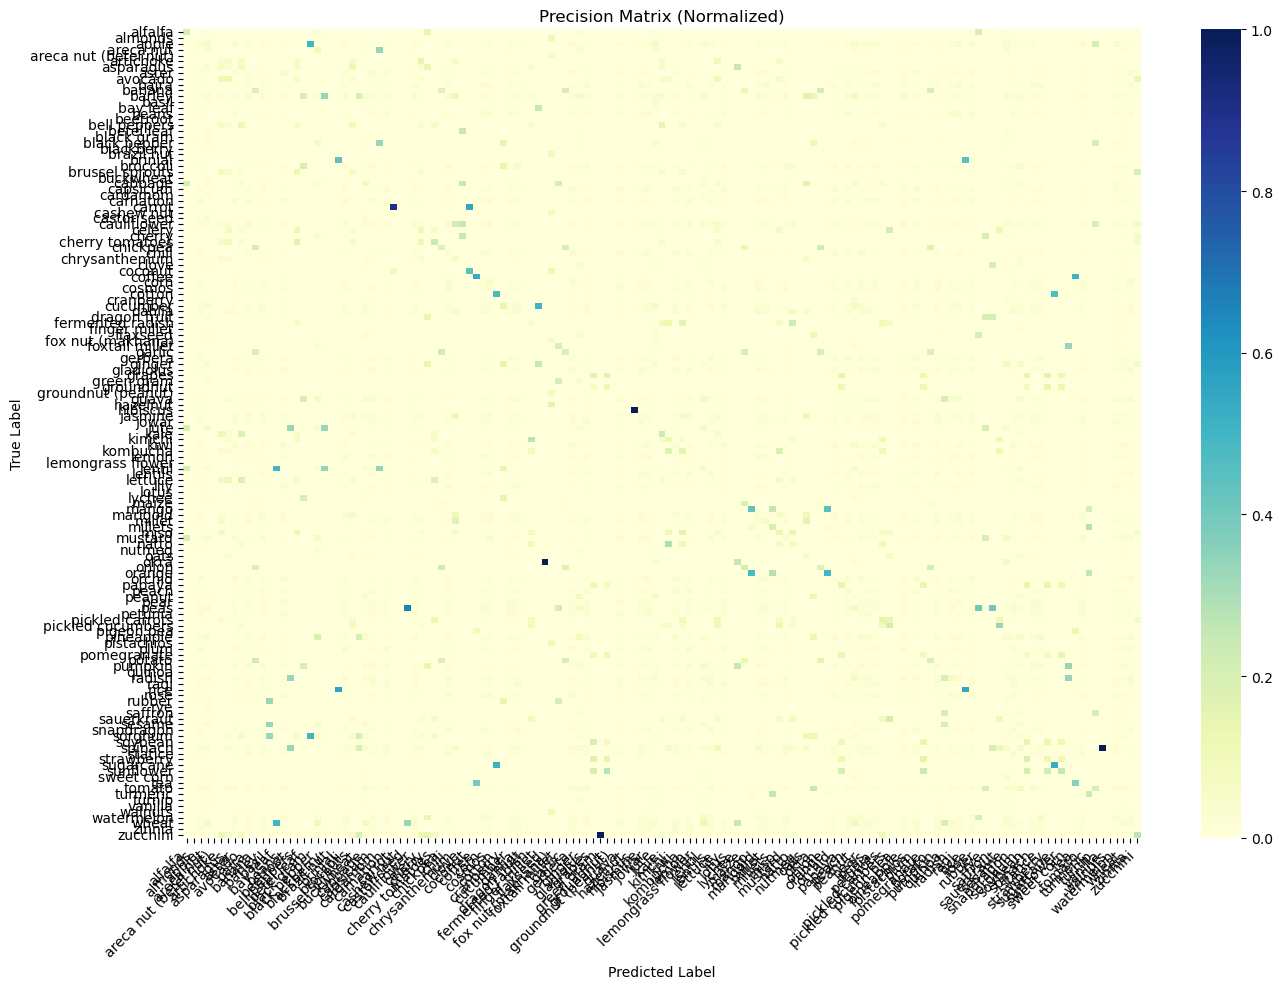


✅ Matrix saved to confusion_matrix_highres.png


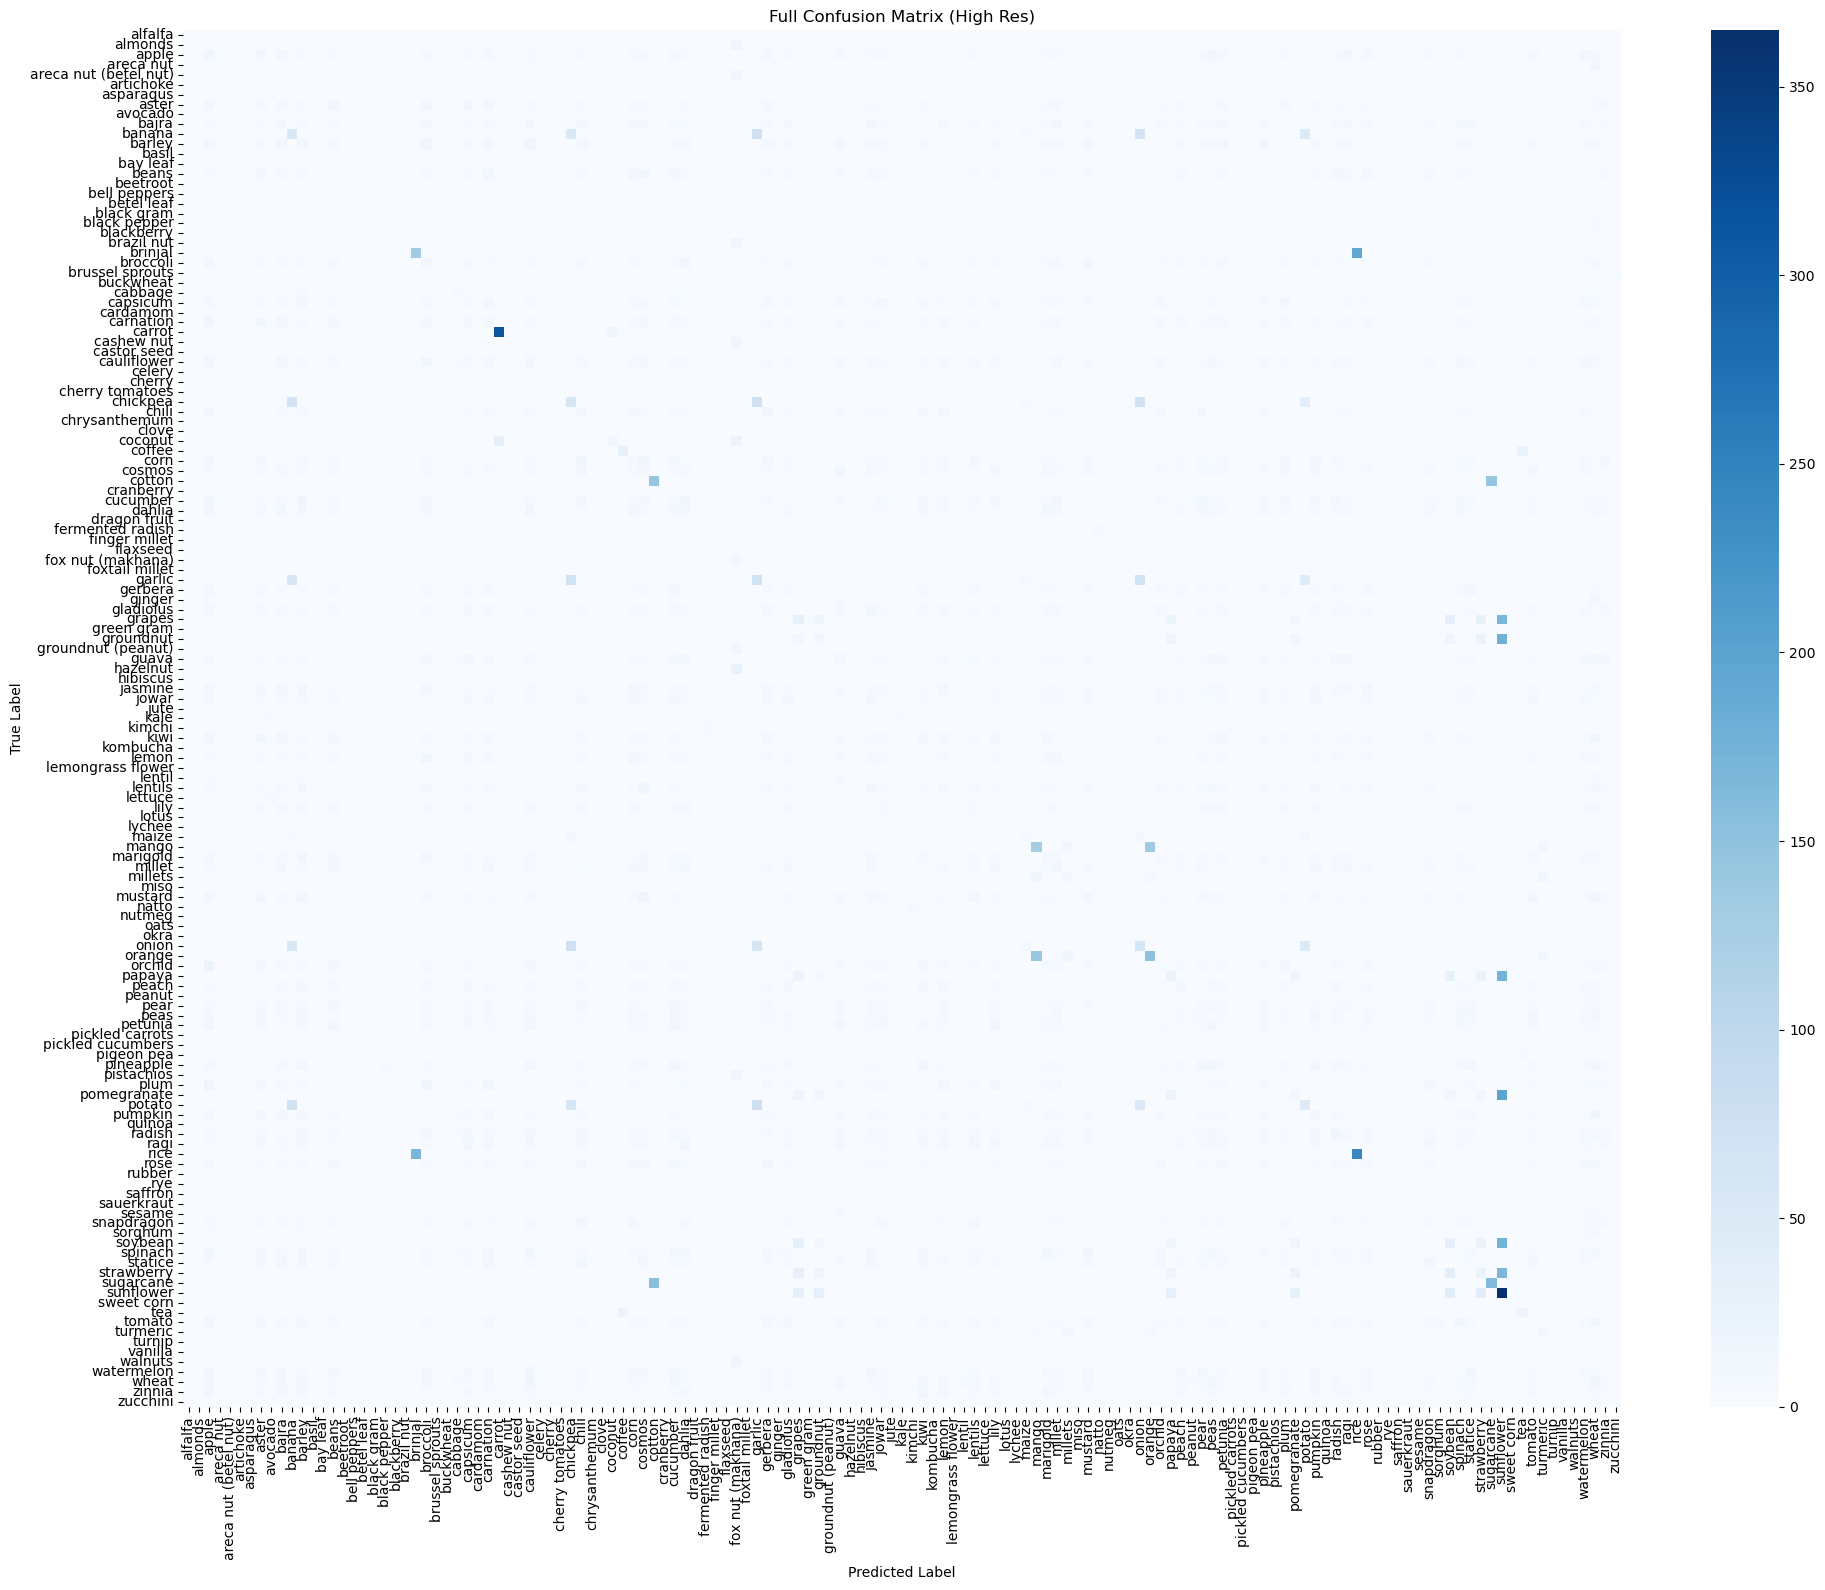

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_score, recall_score,
    f1_score, confusion_matrix
)
from collections import Counter

# ✅ Parse values like "50-80" → 65
def parse_range(val):
    try:
        if isinstance(val, str) and '-' in val:
            low, high = map(float, val.split('-'))
            return (low + high) / 2
        return float(val)
    except:
        return np.nan

# ✅ Load dataset
def load_dataset(path):
    return pd.read_csv(path)

# ✅ Preprocess dataset
def preprocess_for_classification(df):
    required_columns = [
        'N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)',
        'Humidity_(%)', 'Temperature_(°C)', 'Crop Name', 'Season'
    ]
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Missing columns in dataset: {missing_cols}")
    
    df = df.dropna(subset=required_columns)
    for col in ['N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)', 'Humidity_(%)', 'Temperature_(°C)']:
        df[col] = df[col].apply(parse_range)
    
    df = pd.get_dummies(df, columns=['Season', 'Soil_Type'], drop_first=False)
    
    to_drop = [
        'Sunlight_Intensity (lux)', 'Nitrogen_Solution', 'Phosphorus_Solution',
        'Potassium_Solution', 'Biological_Nitrogen_Solution',
        'Biological_Phosphorus_Solution', 'Biological_Potassium_Solution'
    ]
    df = df.drop(columns=[col for col in to_drop if col in df.columns], errors='ignore')
    df = df.dropna()

    X = df.drop(columns=['Crop Name'])
    y = df['Crop Name'].str.lower()
    return X, y

# ✅ Train classifier
def train_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, X_test, y_test, y_pred

# ✅ Confusion Matrix (Top-N labels)
def plot_confusion_matrix_topN(y_test, y_pred, top_n=20):
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    label_counts = Counter(y_test)
    top_labels = [label for label, _ in label_counts.most_common(top_n)]
    indices = [np.where(labels == label)[0][0] for label in top_labels]
    cm_top = cm[np.ix_(indices, indices)]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_top, annot=True, fmt="d", cmap="Blues",
                xticklabels=top_labels, yticklabels=top_labels,
                annot_kws={"size":12})
    plt.title("Top-N Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ✅ Precision Matrix (normalized by predicted labels)
def plot_precision_matrix(y_test, y_pred):
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=0, keepdims=True)
    cm = np.nan_to_num(cm)  # Replace NaN with 0

    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=False, cmap='YlGnBu',
                xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix (Normalized)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ✅ Evaluate model
def evaluate_model(y_test, y_pred):
    print("\n📊 Classification Report:\n")
    print(classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

    # 🔍 Plot Top Confusion and Precision Matrix
    plot_confusion_matrix_topN(y_test, y_pred, top_n=20)
    plot_precision_matrix(y_test, y_pred)

# ✅ Optional: Save matrix to file
def save_matrix_as_file(y_test, y_pred, filename="confusion_matrix_highres.png"):
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=False, cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title("Full Confusion Matrix (High Res)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\n✅ Matrix saved to {filename}")

# ✅ Main Execution
if __name__ == "__main__":
    dataset_path = r"C:\Users\suman\OneDrive\Desktop\dataset\soil_nutrients1.csv"  # Update this path

    df = load_dataset(dataset_path)
    X, y = preprocess_for_classification(df)

    model, X_test, y_test, y_pred = train_classifier(X, y)
    evaluate_model(y_test, y_pred)

    # Optional: Save the full matrix to a high-res file
    save_matrix_as_file(y_test, y_pred)



📊 Classification Report:



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricW

                       precision    recall  f1-score   support

              alfalfa       0.20      0.07      0.10        15
              almonds       0.00      0.00      0.00        18
            anthurium       0.00      0.00      0.00         0
                apple       0.03      0.05      0.04       309
            areca nut       0.04      0.07      0.05        46
areca nut (betel nut)       0.00      0.00      0.00        13
            artichoke       0.03      0.06      0.04        18
            asparagus       0.03      0.03      0.03        32
                aster       0.03      0.03      0.03       274
              avocado       0.00      0.00      0.00        19
                bajra       0.03      0.04      0.03       291
               banana       0.18      0.18      0.18       309
               barley       0.03      0.04      0.03       363
                basil       0.00      0.00      0.00        13
             bay leaf       0.00      0.00      0.00  

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.09462956811590731
F1 Score: 0.08738185799367308


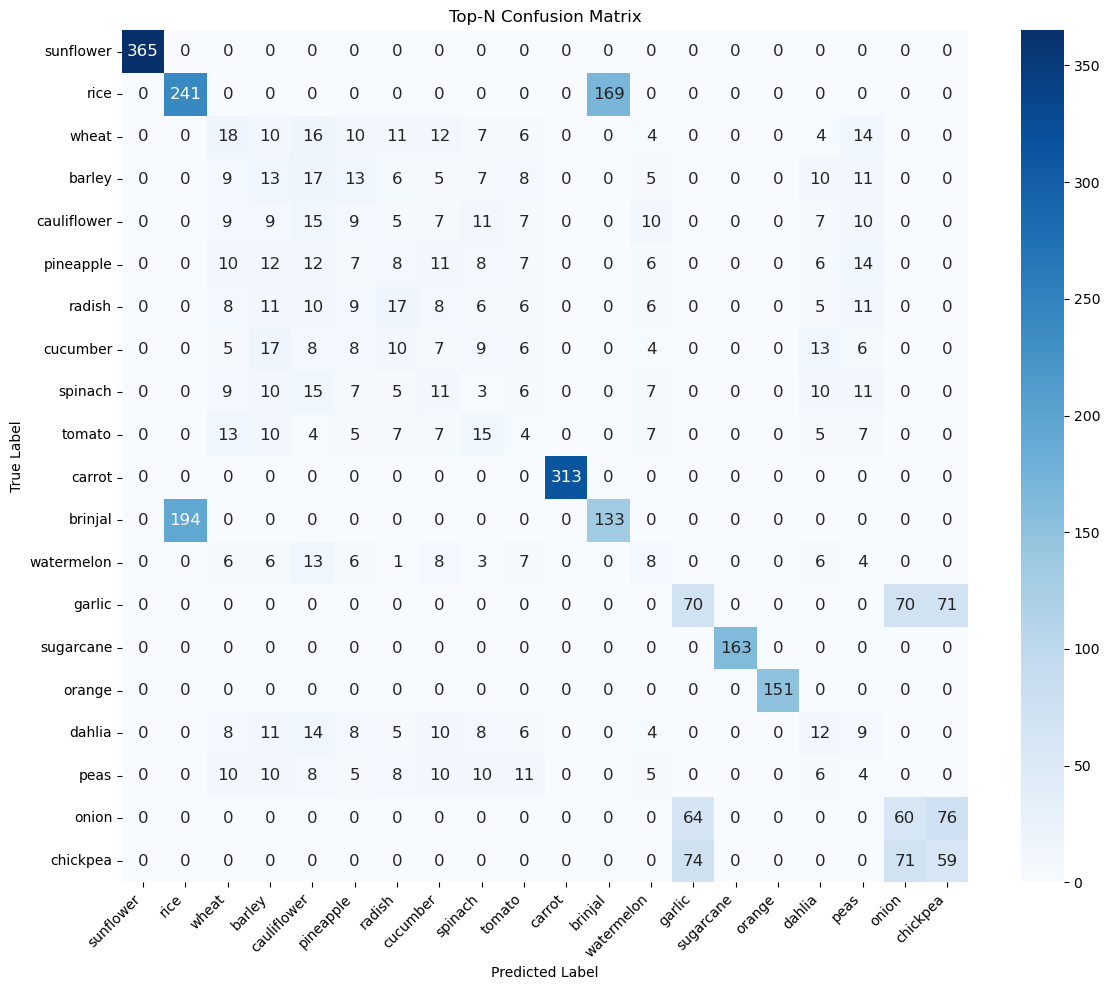

C:\Users\suman\AppData\Local\Temp\ipykernel_3304\4098148367.py:91: RuntimeWarning: invalid value encountered in divide
  cm_precision = cm.astype('float') / cm.sum(axis=0, keepdims=True)
C:\Users\suman\AppData\Local\Temp\ipykernel_3304\4098148367.py:109: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


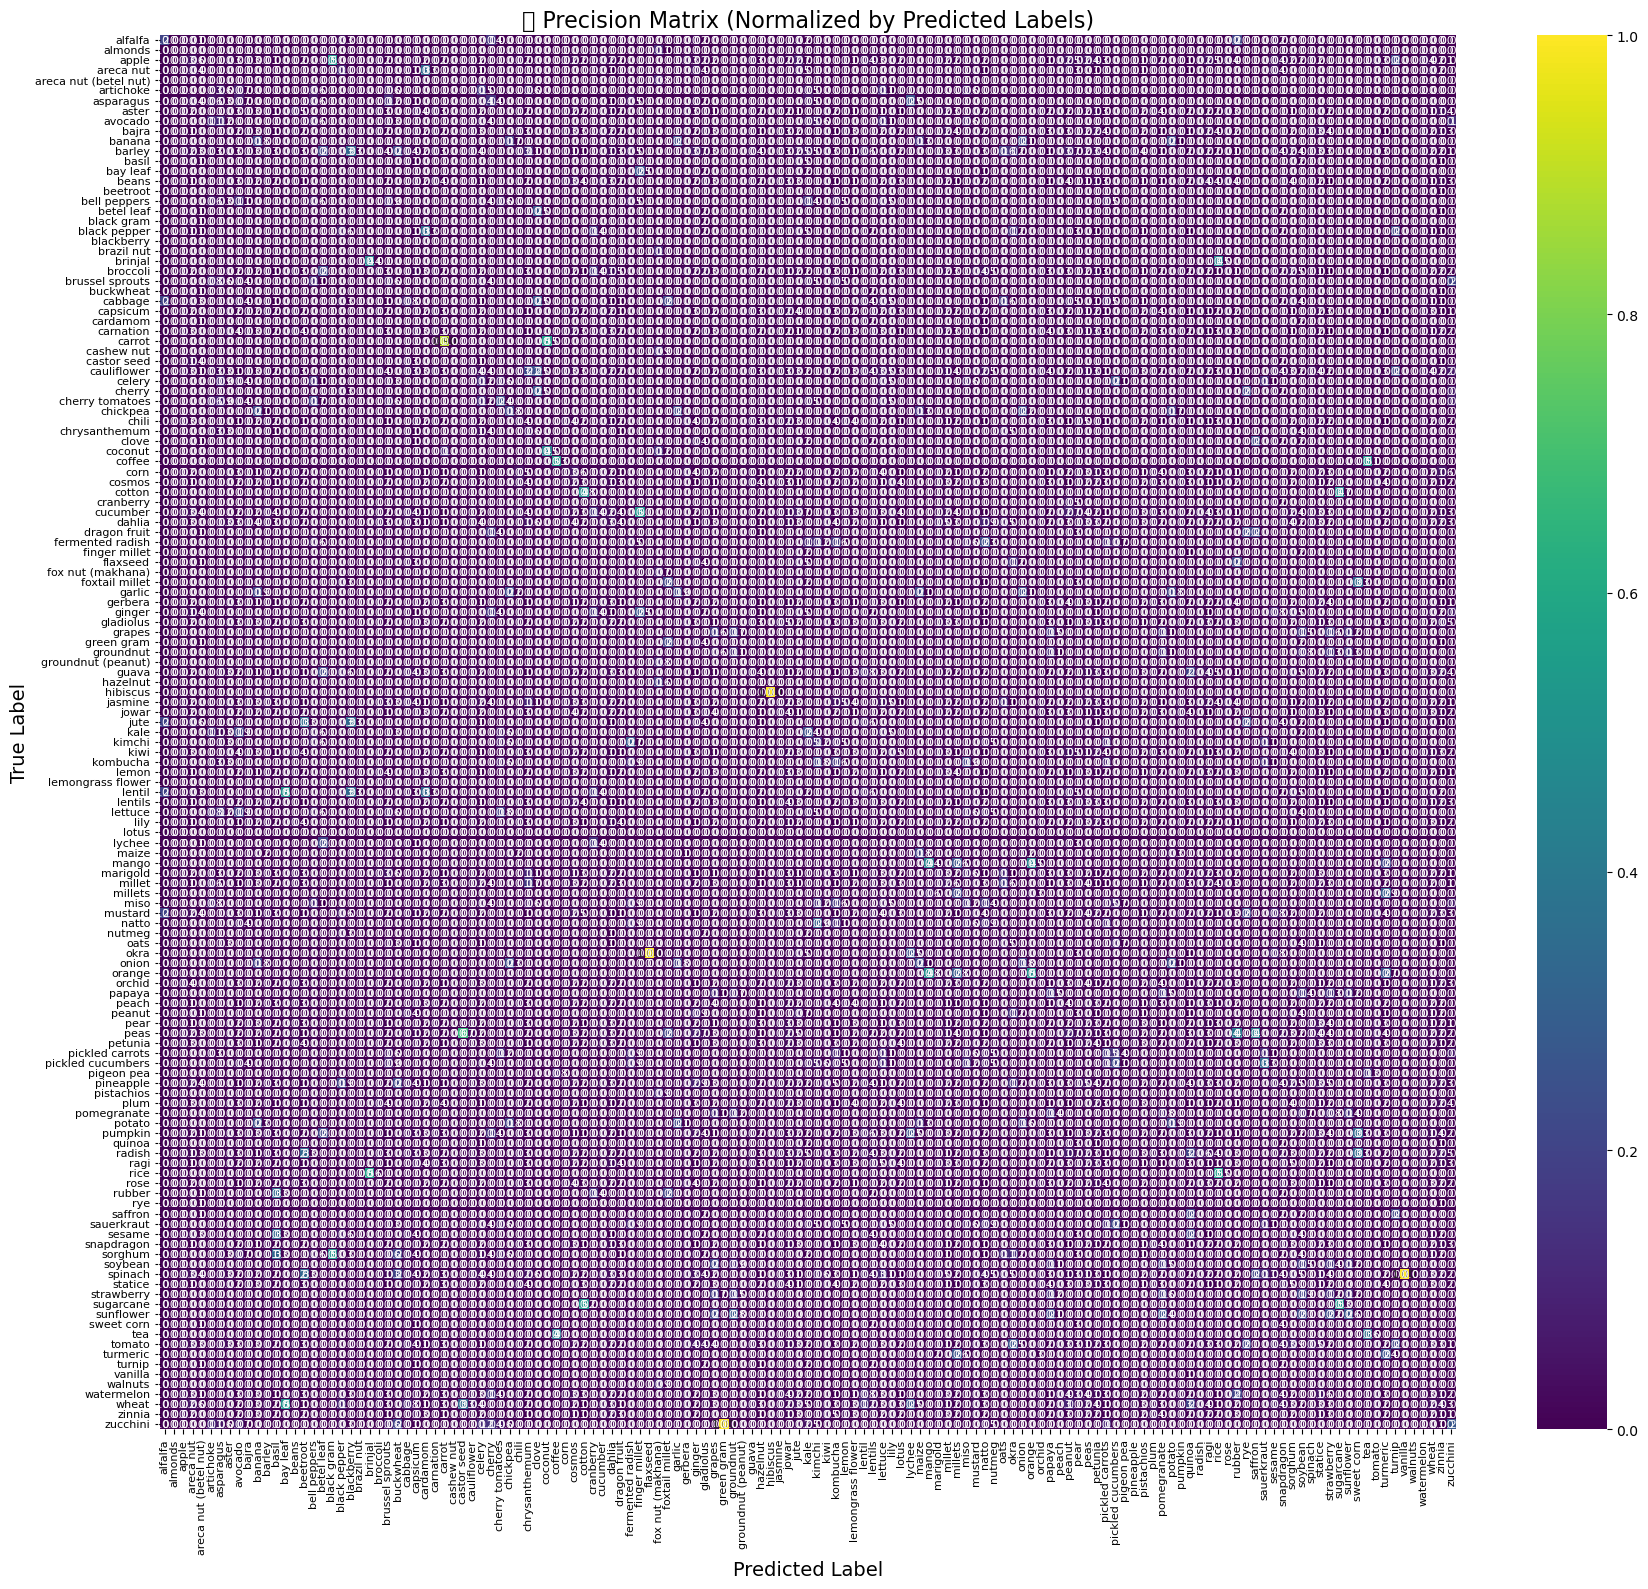

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_score, recall_score,
    f1_score, confusion_matrix
)
from collections import Counter

# ✅ Parse values like "50-80" → 65
def parse_range(val):
    try:
        if isinstance(val, str) and '-' in val:
            low, high = map(float, val.split('-'))
            return (low + high) / 2
        return float(val)
    except:
        return np.nan

# ✅ Load dataset
def load_dataset(path):
    return pd.read_csv(path)

# ✅ Preprocess dataset
def preprocess_for_classification(df):
    required_columns = [
        'N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)',
        'Humidity_(%)', 'Temperature_(°C)', 'Crop Name', 'Season'
    ]
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Missing columns in dataset: {missing_cols}")
    
    df = df.dropna(subset=required_columns)

    for col in ['N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)', 'Humidity_(%)', 'Temperature_(°C)']:
        df[col] = df[col].apply(parse_range)
    
    df = pd.get_dummies(df, columns=['Season', 'Soil_Type'], drop_first=False)
    
    to_drop = [
        'Sunlight_Intensity (lux)', 'Nitrogen_Solution', 'Phosphorus_Solution',
        'Potassium_Solution', 'Biological_Nitrogen_Solution',
        'Biological_Phosphorus_Solution', 'Biological_Potassium_Solution'
    ]
    df = df.drop(columns=[col for col in to_drop if col in df.columns], errors='ignore')
    df = df.dropna()

    X = df.drop(columns=['Crop Name'])
    y = df['Crop Name'].str.lower()

    return X, y

# ✅ Train classifier
def train_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, X_test, y_test, y_pred

# ✅ Confusion Matrix for Top-N frequent classes
def plot_confusion_matrix_topN(y_test, y_pred, top_n=20):
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    label_counts = Counter(y_test)
    top_labels = [label for label, _ in label_counts.most_common(top_n)]
    indices = [np.where(labels == label)[0][0] for label in top_labels]
    cm_top = cm[np.ix_(indices, indices)]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_top, annot=True, fmt="d", cmap="Blues",
                xticklabels=top_labels, yticklabels=top_labels,
                annot_kws={"size":12})
    plt.title("Top-N Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ✅ Enhanced Precision Matrix (Normalized by Prediction)
def plot_precision_matrix(y_test, y_pred):
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    # Normalize by predicted label (column-wise)
    cm_precision = cm.astype('float') / cm.sum(axis=0, keepdims=True)
    cm_precision = np.nan_to_num(cm_precision)

    plt.figure(figsize=(18, 16))
    sns.heatmap(
        cm_precision,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={"size": 8}
    )
    plt.title("🔍 Precision Matrix (Normalized by Predicted Labels)", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

# ✅ Evaluation Function
def evaluate_model(y_test, y_pred):
    print("\n📊 Classification Report:\n")
    print(classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

    # Plot Top-N Confusion and Precision Matrices
    plot_confusion_matrix_topN(y_test, y_pred, top_n=20)
    plot_precision_matrix(y_test, y_pred)

# ✅ Save Precision Matrix to File (Optional)
def save_precision_matrix(y_test, y_pred, filename="precision_matrix_highres.png"):
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_precision = cm.astype('float') / cm.sum(axis=0, keepdims=True)
    cm_precision = np.nan_to_num(cm_precision)

    plt.figure(figsize=(20, 18))
    sns.heatmap(cm_precision, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 6})
    plt.title("Precision Matrix (High Resolution)", fontsize=18)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(rotation=0, fontsize=6)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"✅ Saved precision matrix as: {filename}")

# ✅ Main Execution
if __name__ == "__main__":
    dataset_path = r"C:\Users\suman\OneDrive\Desktop\dataset\soil_nutrients1.csv"  # 🔁 Update path if needed

    df = load_dataset(dataset_path)
    X, y = preprocess_for_classification(df)

    model, X_test, y_test, y_pred = train_classifier(X, y)
    evaluate_model(y_test, y_pred)

    # Optional: Save matrix as image
    # save_precision_matrix(y_test, y_pred)



📊 Classification Report:



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricW

                       precision    recall  f1-score   support

              alfalfa       0.20      0.07      0.10        15
              almonds       0.00      0.00      0.00        18
            anthurium       0.00      0.00      0.00         0
                apple       0.03      0.05      0.04       309
            areca nut       0.04      0.07      0.05        46
areca nut (betel nut)       0.00      0.00      0.00        13
            artichoke       0.03      0.06      0.04        18
            asparagus       0.03      0.03      0.03        32
                aster       0.03      0.03      0.03       274
              avocado       0.00      0.00      0.00        19
                bajra       0.03      0.04      0.03       291
               banana       0.18      0.18      0.18       309
               barley       0.03      0.04      0.03       363
                basil       0.00      0.00      0.00        13
             bay leaf       0.00      0.00      0.00  

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.09462956811590731
F1 Score: 0.08738185799367308


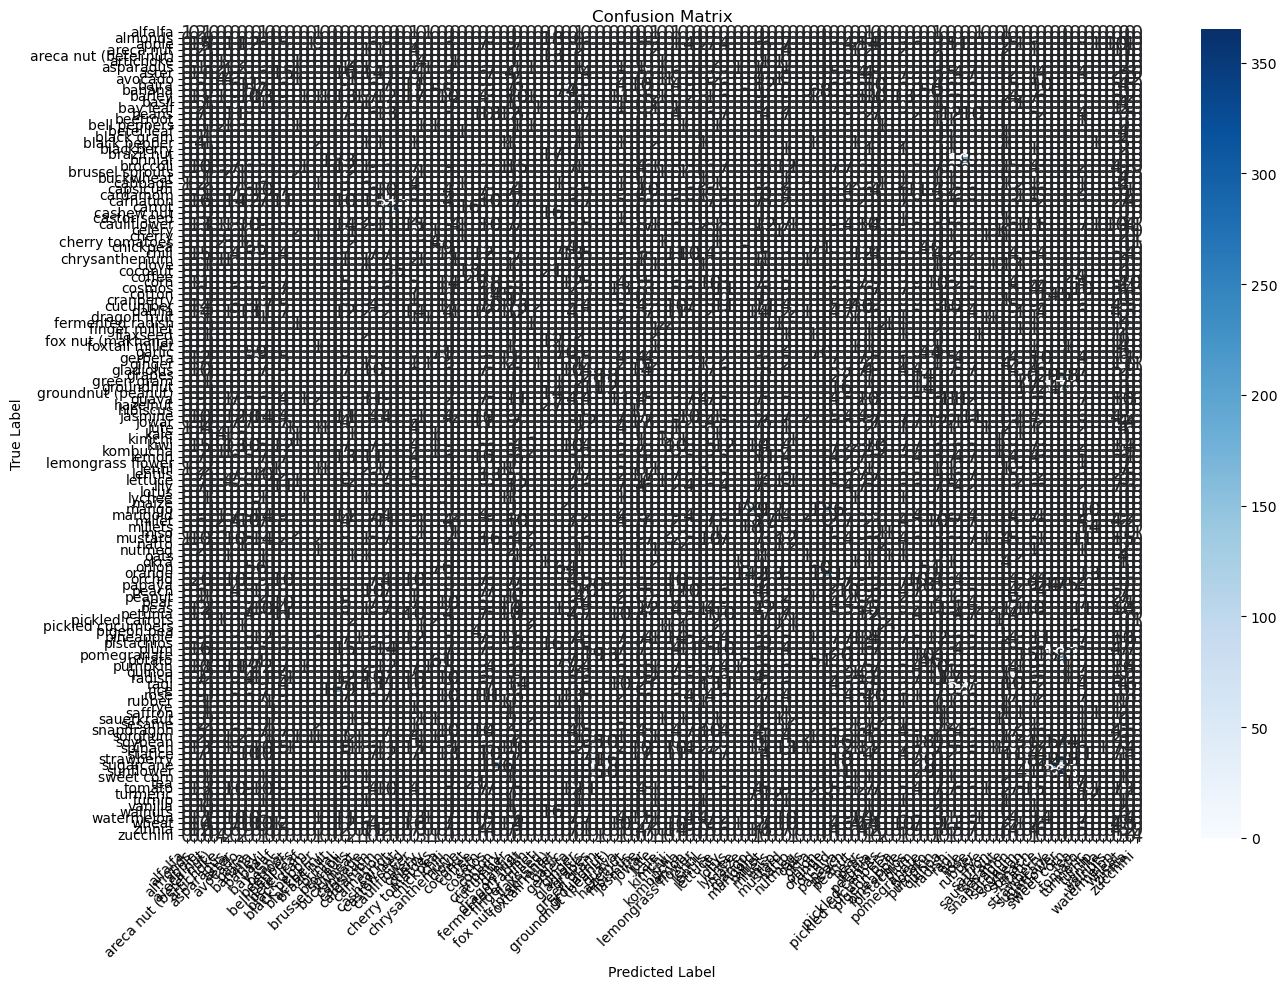

C:\Users\suman\AppData\Local\Temp\ipykernel_3304\483464762.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette='pastel')
C:\Users\suman\AppData\Local\Temp\ipykernel_3304\483464762.py:129: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


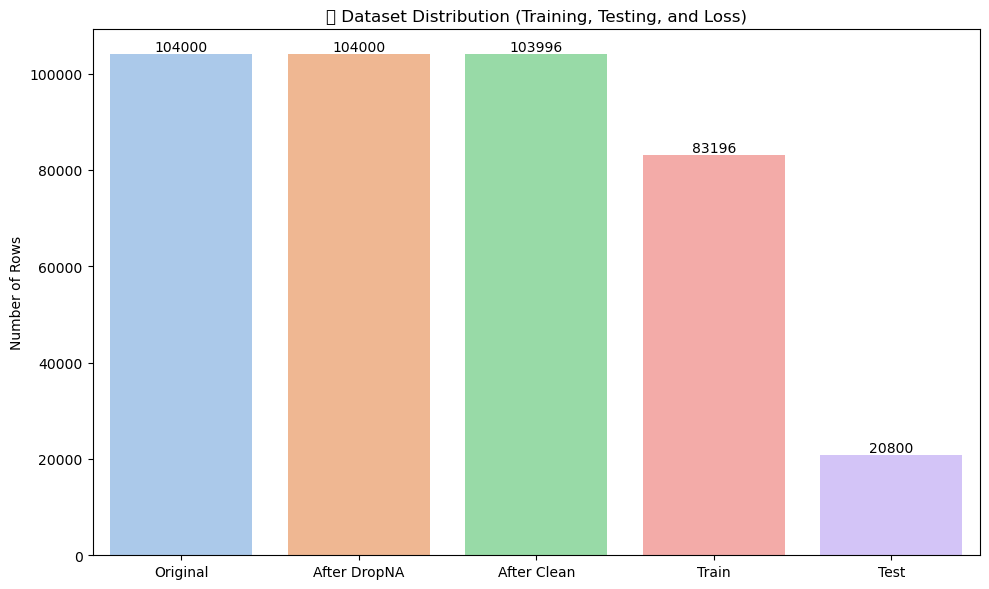


Enter soil and environment values:


N (kg/ha):  458
P (kg/ha):  56
K (kg/ha):  85
pH:  5.3
Moisture (%):  43
Humidity (%):  58
Temperature (°C):  20


Available Seasons: ['Kharif', 'Perennial', 'Rabi', 'Summer', 'Winter', 'Zaid']


Enter season (as above):  Zaid


Available Soil Types: ['Alluvial', 'Alluvial soil', 'Black', 'Black Soil', 'Clayey soils', 'Laterite', 'Laterite Soil', 'Loamy soil', 'Red', 'Red soil', 'Sandy loam', 'Sandy soil']


Enter soil type (as above):  Sandy soil



🌱 Predicted Crop: Carrot


In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_score, recall_score,
    f1_score, confusion_matrix
)

# ✅ Function to parse values like "50-80" → 65
def parse_range(val):
    try:
        if isinstance(val, str) and '-' in val:
            low, high = map(float, val.split('-'))
            return (low + high) / 2
        return float(val)
    except:
        return np.nan

# ✅ Load dataset
def load_dataset(path):
    return pd.read_csv(path)

# ✅ Preprocess dataset for classification
def preprocess_for_classification(df):
    original_size = len(df)

    required_columns = [
        'N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)',
        'Humidity_(%)', 'Temperature_(°C)', 'Crop Name', 'Season'
    ]
    df = df.dropna(subset=required_columns)
    cleaned_size = len(df)

    for col in ['N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)', 'Humidity_(%)', 'Temperature_(°C)']:
        df[col] = df[col].apply(parse_range)

    df = pd.get_dummies(df, columns=['Season', 'Soil_Type'], drop_first=False)

    drop_cols = [
        'Sunlight_Intensity (lux)', 'Nitrogen_Solution', 'Phosphorus_Solution',
        'Potassium_Solution', 'Biological_Nitrogen_Solution',
        'Biological_Phosphorus_Solution', 'Biological_Potassium_Solution'
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    df = df.dropna()
    final_size = len(df)

    X = df.drop(columns=['Crop Name'])
    y = df['Crop Name'].str.lower()

    return X, y, original_size, cleaned_size, final_size

# ✅ Train classifier
def train_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, X_train, X_test, y_train, y_test, y_pred

# ✅ Evaluate model with improved confusion matrix visualization
def evaluate_model(y_test, y_pred):
    print("\n📊 Classification Report:\n")
    print(classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        cm, annot=True, fmt="d", xticklabels=np.unique(y_test),
        yticklabels=np.unique(y_test), cmap="Blues", annot_kws={"size":14}
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# ✅ Get user input for prediction
def get_user_input(feature_columns):
    print("\nEnter soil and environment values:")
    user_dict = {col: 0 for col in feature_columns}  # default 0 for all features

    user_dict['N (kg/ha)'] = float(input("N (kg/ha): "))
    user_dict['P (kg/ha)'] = float(input("P (kg/ha): "))
    user_dict['K (kg/ha)'] = float(input("K (kg/ha): "))
    user_dict['pH'] = float(input("pH: "))
    user_dict['Moisture_(%)'] = float(input("Moisture (%): "))
    user_dict['Humidity_(%)'] = float(input("Humidity (%): "))
    user_dict['Temperature_(°C)'] = float(input("Temperature (°C): "))

    season_columns = [col for col in feature_columns if col.startswith("Season_")]
    soil_columns = [col for col in feature_columns if col.startswith("Soil_Type_")]

    if season_columns:
        print("Available Seasons:", [col.replace("Season_", "") for col in season_columns])
        season = input("Enter season (as above): ").strip()
        if f"Season_{season}" in feature_columns:
            user_dict[f"Season_{season}"] = 1

    if soil_columns:
        print("Available Soil Types:", [col.replace("Soil_Type_", "") for col in soil_columns])
        soil = input("Enter soil type (as above): ").strip()
        if f"Soil_Type_{soil}" in feature_columns:
            user_dict[f"Soil_Type_{soil}"] = 1

    return pd.DataFrame([user_dict])

# ✅ Plot data usage and loss
def plot_data_distribution(original, cleaned, final, train_size, test_size):
    categories = ['Original', 'After DropNA', 'After Clean', 'Train', 'Test']
    values = [original, cleaned, final, train_size, test_size]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=categories, y=values, palette='pastel')
    plt.title("📈 Dataset Distribution (Training, Testing, and Loss)")
    plt.ylabel("Number of Rows")
    for i, val in enumerate(values):
        plt.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

# ✅ Main script
if __name__ == "__main__":
    dataset_path = r"C:\Users\suman\OneDrive\Desktop\dataset\soil_nutrients1.csv"  # 🛠️ Update path

    df = load_dataset(dataset_path)
    X, y, original_size, cleaned_size, final_size = preprocess_for_classification(df)

    model, X_train, X_test, y_train, y_test, y_pred = train_classifier(X, y)
    evaluate_model(y_test, y_pred)

    plot_data_distribution(original_size, cleaned_size, final_size, len(X_train), len(X_test))

    # 💡 Predict from user input
    user_input_df = get_user_input(X.columns.tolist())
    prediction = model.predict(user_input_df)[0]
    print(f"\n🌱 Predicted Crop: {prediction.capitalize()}")



📊 Classification Report:



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricW

                       precision    recall  f1-score   support

              alfalfa       0.20      0.07      0.10        15
              almonds       0.00      0.00      0.00        18
            anthurium       0.00      0.00      0.00         0
                apple       0.03      0.05      0.04       309
            areca nut       0.04      0.07      0.05        46
areca nut (betel nut)       0.00      0.00      0.00        13
            artichoke       0.03      0.06      0.04        18
            asparagus       0.03      0.03      0.03        32
                aster       0.03      0.03      0.03       274
              avocado       0.00      0.00      0.00        19
                bajra       0.03      0.04      0.03       291
               banana       0.18      0.18      0.18       309
               barley       0.03      0.04      0.03       363
                basil       0.00      0.00      0.00        13
             bay leaf       0.00      0.00      0.00  

D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.09462956811590731
F1 Score: 0.08738185799367308


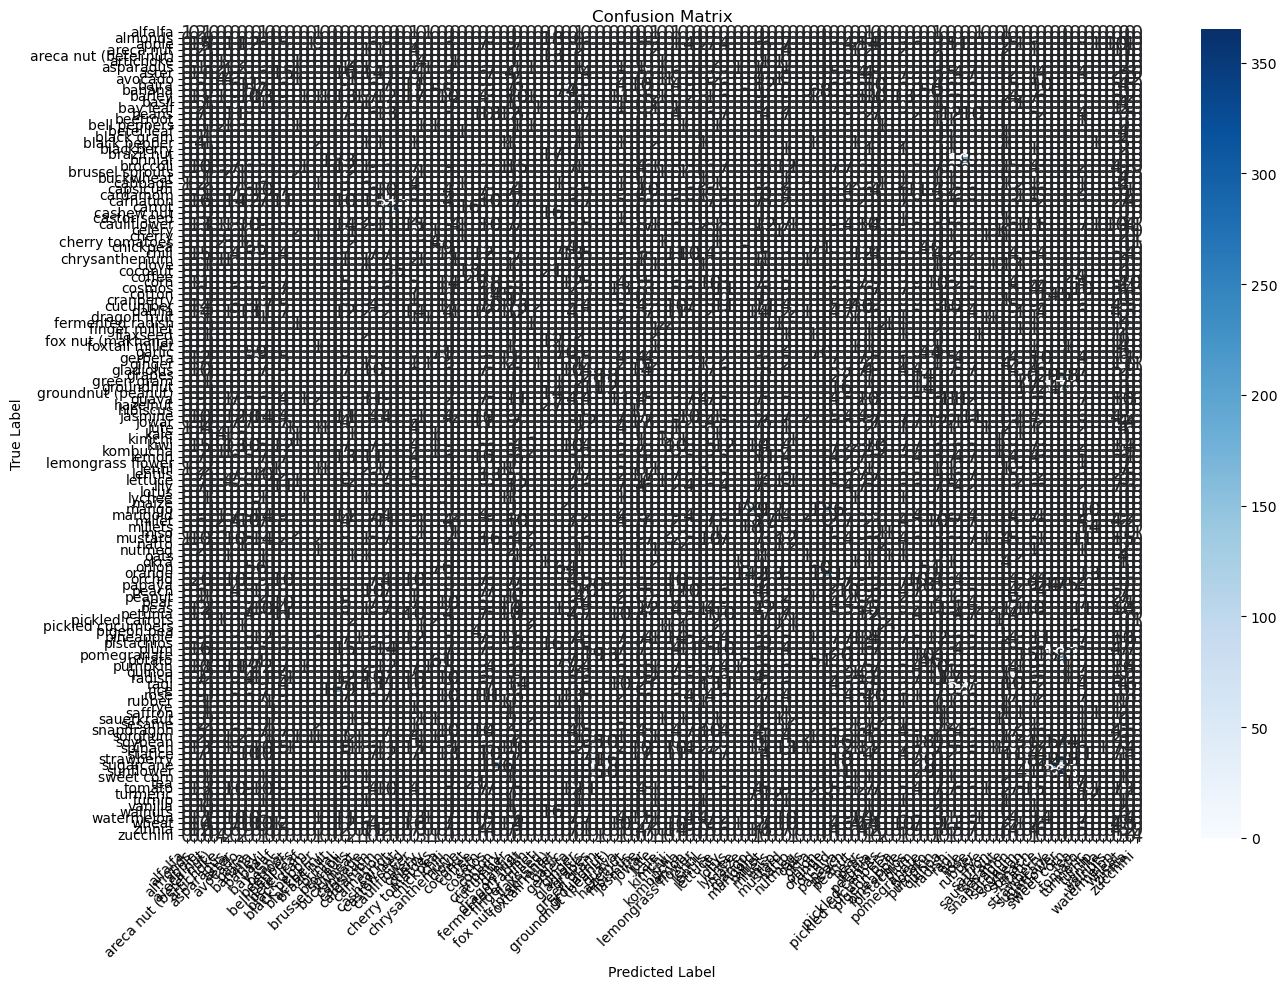

C:\Users\suman\AppData\Local\Temp\ipykernel_3304\2519305922.py:130: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


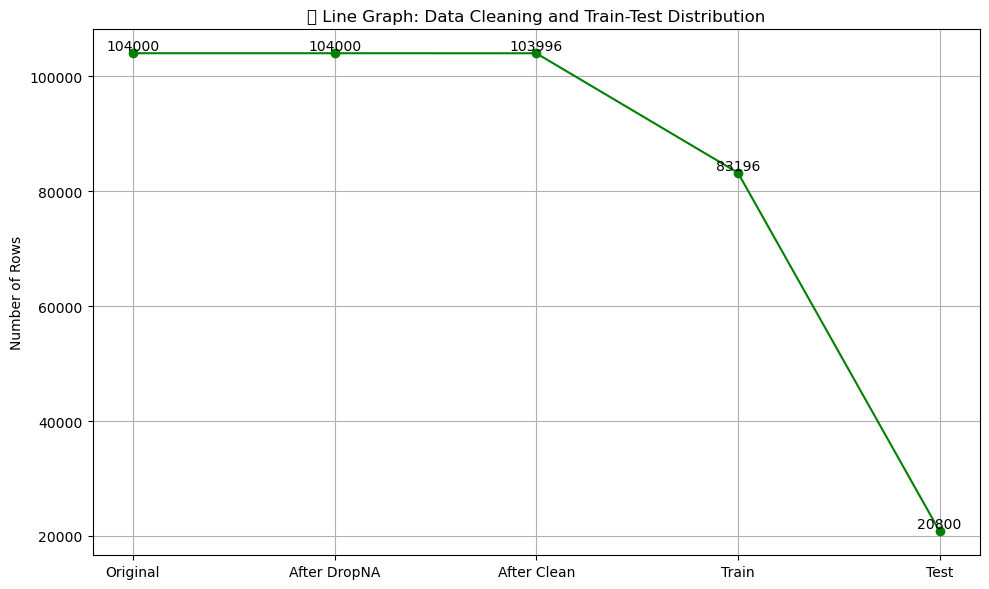


Enter soil and environment values:


N (kg/ha):  146
P (kg/ha):  56
K (kg/ha):  43
pH:  5.9
Moisture (%):  56
Humidity (%):  48
Temperature (°C):  20


Available Seasons: ['Kharif', 'Perennial', 'Rabi', 'Summer', 'Winter', 'Zaid']


Enter season (as above):  Rabi


Available Soil Types: ['Alluvial', 'Alluvial soil', 'Black', 'Black Soil', 'Clayey soils', 'Laterite', 'Laterite Soil', 'Loamy soil', 'Red', 'Red soil', 'Sandy loam', 'Sandy soil']


Enter soil type (as above):  Black



🌱 Predicted Crop: Natto


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_score, recall_score,
    f1_score, confusion_matrix
)

# ✅ Function to parse values like "50-80" → 65
def parse_range(val):
    try:
        if isinstance(val, str) and '-' in val:
            low, high = map(float, val.split('-'))
            return (low + high) / 2
        return float(val)
    except:
        return np.nan

# ✅ Load dataset
def load_dataset(path):
    return pd.read_csv(path)

# ✅ Preprocess dataset for classification
def preprocess_for_classification(df):
    original_size = len(df)

    required_columns = [
        'N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)',
        'Humidity_(%)', 'Temperature_(°C)', 'Crop Name', 'Season'
    ]
    df = df.dropna(subset=required_columns)
    cleaned_size = len(df)

    for col in ['N (kg/ha)', 'P (kg/ha)', 'K (kg/ha)', 'pH', 'Moisture_(%)', 'Humidity_(%)', 'Temperature_(°C)']:
        df[col] = df[col].apply(parse_range)

    df = pd.get_dummies(df, columns=['Season', 'Soil_Type'], drop_first=False)

    drop_cols = [
        'Sunlight_Intensity (lux)', 'Nitrogen_Solution', 'Phosphorus_Solution',
        'Potassium_Solution', 'Biological_Nitrogen_Solution',
        'Biological_Phosphorus_Solution', 'Biological_Potassium_Solution'
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    df = df.dropna()
    final_size = len(df)

    X = df.drop(columns=['Crop Name'])
    y = df['Crop Name'].str.lower()

    return X, y, original_size, cleaned_size, final_size

# ✅ Train classifier
def train_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return clf, X_train, X_test, y_train, y_test, y_pred

# ✅ Evaluate model
def evaluate_model(y_test, y_pred):
    print("\n📊 Classification Report:\n")
    print(classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_pred, average='macro'))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        cm, annot=True, fmt="d", xticklabels=np.unique(y_test),
        yticklabels=np.unique(y_test), cmap="Blues", annot_kws={"size":14}
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# ✅ Get user input for prediction
def get_user_input(feature_columns):
    print("\nEnter soil and environment values:")
    user_dict = {col: 0 for col in feature_columns}

    user_dict['N (kg/ha)'] = float(input("N (kg/ha): "))
    user_dict['P (kg/ha)'] = float(input("P (kg/ha): "))
    user_dict['K (kg/ha)'] = float(input("K (kg/ha): "))
    user_dict['pH'] = float(input("pH: "))
    user_dict['Moisture_(%)'] = float(input("Moisture (%): "))
    user_dict['Humidity_(%)'] = float(input("Humidity (%): "))
    user_dict['Temperature_(°C)'] = float(input("Temperature (°C): "))

    season_columns = [col for col in feature_columns if col.startswith("Season_")]
    soil_columns = [col for col in feature_columns if col.startswith("Soil_Type_")]

    if season_columns:
        print("Available Seasons:", [col.replace("Season_", "") for col in season_columns])
        season = input("Enter season (as above): ").strip()
        if f"Season_{season}" in feature_columns:
            user_dict[f"Season_{season}"] = 1

    if soil_columns:
        print("Available Soil Types:", [col.replace("Soil_Type_", "") for col in soil_columns])
        soil = input("Enter soil type (as above): ").strip()
        if f"Soil_Type_{soil}" in feature_columns:
            user_dict[f"Soil_Type_{soil}"] = 1

    return pd.DataFrame([user_dict])

# ✅ Line graph for data usage/loss
def plot_data_distribution_line(original, cleaned, final, train_size, test_size):
    stages = ['Original', 'After DropNA', 'After Clean', 'Train', 'Test']
    values = [original, cleaned, final, train_size, test_size]

    plt.figure(figsize=(10, 6))
    plt.plot(stages, values, marker='o', linestyle='-', color='green')
    for i, val in enumerate(values):
        plt.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=10)
    plt.title("📈 Line Graph: Data Cleaning and Train-Test Distribution")
    plt.ylabel("Number of Rows")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ✅ Main script
if __name__ == "__main__":
    dataset_path = r"C:\Users\suman\OneDrive\Desktop\dataset\soil_nutrients1.csv"

    df = load_dataset(dataset_path)
    X, y, original_size, cleaned_size, final_size = preprocess_for_classification(df)

    model, X_train, X_test, y_train, y_test, y_pred = train_classifier(X, y)
    evaluate_model(y_test, y_pred)

    plot_data_distribution_line(original_size, cleaned_size, final_size, len(X_train), len(X_test))

    # 💡 Predict from user input
    user_input_df = get_user_input(X.columns.tolist())
    prediction = model.predict(user_input_df)[0]
    print(f"\n🌱 Predicted Crop: {prediction.capitalize()}")
